1143 miti,
318 ada, 0,6786


old:
897, miti, 0,73
151, ada, 0,64

In [ ]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

## Set parameters

In [ ]:
# Set parameters

# Path to gdrive folder with expert labels
folder_path = Path("/content/drive/MyDrive/CAP/data/input")
# folder_path = Path("/content/drive/MyDrive/CAP/data/25_02_input_old")
# folder_path = Path("/content/drive/MyDrive/CAP/data/input_old")

# Path to gdrive folder with all the action and city dat
# Attention! When changing city data or action data, we will change the underlaying data
# that the experts used for comparison. While it could be ok to change a feature if it essentially
# still represents the same information we should not change the data itself like emissions
# from the cities as this will have direct impact on the made comparisons by the experts.
path_city_data = "/content/drive/MyDrive/CAP/data/references/city_data.json"

# Uncommment this line for current production actions list
# path_action_data = "/content/drive/MyDrive/CAP/data/references/merged.json"

# Uncomment this line for loading actions with reduced hazards
# path_action_data = "/content/drive/MyDrive/CAP/data/references/merged_main_hazards.json"

# Uncomment this line for loading actions with individual adaptation effectiveness scores
path_action_data = "/content/drive/MyDrive/CAP/data/references/merged_individual_adaptation_effectiveness.json"

# Remove 'Unsure' labels together with 'irrelevant'
remove_unsure = True

# Remove duplicates (same action pair with same label)
remove_duplicates = False

# Remove inonsistencies (same action pair with different label)
remove_inconsistencies = False

# Remove mitigation actions (e.g. for testing or training different classifiers)
remove_mitigation_actions_flag = False

# Remove adaptation actions (e.g. for testing or training different classifiers)
remove_adaptation_actions_flag = False

# Training features
mitigation_features = False
adaptation_features = False
mitigation_adaptation_features = True

# Set training flag
# If flag is true, scaler and model will learn and save their artifacts
# If flag is false, scaler and model will look for artifacts to load parameters
training = True


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data_from_folder(folder_path):
    """
    Reads all JSON files in the specified folder and returns a combined pandas DataFrame.
    Assumes each JSON file contains a list of comparison dictionaries.
    """
    all_data = []
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    if not json_files:
        print(f"No JSON files found in {folder_path}. Please check the folder path.")
        return pd.DataFrame()

    for file in json_files:
        try:
            with open(file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                # If the JSON file contains a list of dictionaries, extend the list.
                if isinstance(data, list):
                    all_data.extend(data)
                else:
                    print(f"Unrecognized data format in file: {file}")
        except Exception as e:
            print(f"Error reading {file}: {e}")

    df = pd.DataFrame(all_data)
    return df

In [ ]:
def perform_eda(df):
    """
    Performs exploratory data analysis on the DataFrame and prints:
      - Overall count of comparisons.
      - Comparisons count broken down per city.
      - Total unique actions overall.
      - Unique actions count per city.
      - Ranking (i.e. win counts) of preferred actions per city (top 10 for each city).
    """
    print("=== Exploratory Data Analysis ===")

    # 1. Overall count of comparisons (each row is a comparison)
    total_comparisons = len(df)
    actionA_preferred = (df['PreferredAction'] == df['ActionA']).sum()
    actionB_preferred = (df['PreferredAction'] == df['ActionB']).sum()
    total_unsure = (df['PreferredAction'] == "Unsure").sum()
    total_irrelevant = (df['PreferredAction'] == "Irrelevant").sum()
    print(f"\nTotal comparisons made: {total_comparisons}")
    print(f"Action A preferred: {actionA_preferred}")
    print(f"Action B preferred: {actionB_preferred}")
    print(f"Total Unsure: {total_unsure}")
    print(f"Total Irrelevant: {total_irrelevant}")

    # 2. Comparisons broken down per city
    comparisons_per_city = df['CityLocode'].value_counts()
    print("\nComparisons per City:")
    print(comparisons_per_city)

    # 3. Total unique actions overall (from ActionA and ActionB)
    unique_actions_overall = set(df['ActionA'].unique()).union(set(df['ActionB'].unique()))
    print(f"\nTotal unique actions overall: {len(unique_actions_overall)}")

    # 4. Unique actions per city
    print("\nUnique actions per City:")
    for city in sorted(df['CityLocode'].unique()):
        city_df = df[df['CityLocode'] == city]
        unique_actions = set(city_df['ActionA'].unique()).union(set(city_df['ActionB'].unique()))
        print(f"  {city}: {len(unique_actions)} unique actions")

    # 5. Ranking of Preferred Actions per City (Top 10 per City)
    print("\nRanking of Preferred Actions per City (Top 10 per City):")
    for city in sorted(df['CityLocode'].unique()):
        print(f"\nCity: {city}")
        city_pref = df[df['CityLocode'] == city]['PreferredAction'].value_counts().head(10)
        print(city_pref)

    # 6. Check for missing values
    missing_values = df.isnull().sum()
    print("\nMissing Values:")
    print(missing_values)


In [ ]:
def visualize_eda(df):
    """
    Creates visualizations for:
      1. Comparisons per city.
      2. Unique actions per city.
      3. Preferred Action rankings per city using both a heatmap and individual bar charts.
         Only the top 10 preferred actions per city are considered.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(style="whitegrid")

    ### 1. Comparisons per City
    plt.figure(figsize=(10,6))
    city_counts = df['CityLocode'].value_counts().sort_index()
    sns.barplot(x=city_counts.index, y=city_counts.values, palette="Blues_d")
    plt.title("Comparisons per City")
    plt.xlabel("City Locode")
    plt.ylabel("Number of Comparisons")
    plt.show()

    ### 2. Unique Actions per City
    unique_actions_dict = {}
    for city in sorted(df['CityLocode'].unique()):
        city_df = df[df['CityLocode'] == city]
        unique_actions = set(city_df['ActionA'].unique()).union(set(city_df['ActionB'].unique()))
        unique_actions_dict[city] = len(unique_actions)
    unique_actions_series = pd.Series(unique_actions_dict)
    plt.figure(figsize=(10,6))
    sns.barplot(x=unique_actions_series.index, y=unique_actions_series.values, palette="Greens_d")
    plt.title("Unique Actions per City")
    plt.xlabel("City Locode")
    plt.ylabel("Number of Unique Actions")
    plt.show()

    # Compute overall win counts per city and action
    pref_ranking = df.groupby(['CityLocode', 'PreferredAction']).size().reset_index(name="WinCount")

    ### 3. Preferred Action Ranking per City (Individual Bar Charts - Top 10 actions per city)
    for city in sorted(df['CityLocode'].unique()):
        city_data = pref_ranking[pref_ranking['CityLocode'] == city] \
                        .sort_values(by="WinCount", ascending=False).head(20)
        plt.figure(figsize=(10,6))
        sns.barplot(data=city_data, x="PreferredAction", y="WinCount", palette="coolwarm")
        plt.title(f"Preferred Action Ranking for City: {city} (Top 10 Actions)")
        plt.xlabel("Preferred Action")
        plt.ylabel("Win Count")
        plt.xticks(rotation=45)
        plt.show()


In [ ]:
def check_inconsistencies(df):
    """
    Checks for inconsistencies in the comparisons.

    For the same city (CityLocode) and the same two actions (regardless of their order in ActionA/ActionB),
    reports if there are different 'PreferredAction' outcomes.

    Inconsistencies are only counted if the same city and normalized action pair has conflicting labels.
    (Differences in PreferredAction for the same action pair across different cities are not combined.)
    """
    print("\n=== Checking for Inconsistencies in Preferred Actions ===")

    # Work on a copy so that the original DataFrame is not modified
    df_temp = df.copy()

    # Create a normalized key for the action pair, so order does not matter.
    # This key will be used along with CityLocode to group the data.
    df_temp['pair_key'] = df_temp.apply(
        lambda row: tuple(sorted([row['ActionA'], row['ActionB']])), axis=1
    )

    # Group by CityLocode and the normalized action pair
    inconsistent_groups = []
    grouped = df_temp.groupby(['CityLocode', 'pair_key'])
    for (city, pair), group in grouped:
        # If more than one unique PreferredAction exists for this city and pair, flag it.
        if group['PreferredAction'].nunique() > 1:
            inconsistent_groups.append(((city, pair), group))

    count_inconsistencies = len(inconsistent_groups)

    if inconsistent_groups:
        print(f"\nInconsistencies found in {count_inconsistencies} city/pair combination(s):")
        for (city, pair), group in inconsistent_groups:
            print(f"\nCity: {city}, Action Pair: {pair}")
            # print(group[['ActionA', 'ActionB', 'PreferredAction']])
    else:
        print("No inconsistencies found for any city and action pair.")

    return inconsistent_groups, count_inconsistencies

In [ ]:
def check_duplicates(df):
    # Create a copy of the original DataFrame to avoid modifying it
    df_temp = df.copy()

    # Create a ContextPair column that combines CityLocode, PreferredAction, and a normalized (sorted) pair of ActionA and ActionB
    df_temp["ContextPair"] = df_temp.apply(
        lambda row: (
            row["CityLocode"],
            row["PreferredAction"],
            tuple(sorted([row["ActionA"], row["ActionB"]]))
        ),
        axis=1
    )

    # Identify all rows that have duplicates in the ContextPair column.
    # The keep=False flag marks all duplicates (not just subsequent ones).
    duplicate_rows = df_temp[df_temp.duplicated("ContextPair", keep=False)]

    # Print the duplicate rows and the count
    print("Rows with duplicate city action pair and same preferred action:")
    print(duplicate_rows)
    print(f"\nTotal number of duplicate rows: {len(duplicate_rows)}")

    return duplicate_rows


In [ ]:
def check_inconsistencies_and_percentage(df):
    """
    Checks for inconsistencies in the comparisons and calculates the percentage of inconsistent
    pairs among those pairs that have multiple rankings.

    For the same city (CityLocode) and the same two actions (order-independent),
    this function identifies groups with multiple entries and then flags those where
    the 'PreferredAction' values conflict.
    """
    print("\n=== Checking for Inconsistencies in Preferred Actions ===")

    # Work on a copy so that the original DataFrame is not modified.
    df_temp = df.copy()

    # Create a normalized key for the action pair (order does not matter).
    df_temp['pair_key'] = df_temp.apply(
        lambda row: tuple(sorted([row['ActionA'], row['ActionB']])), axis=1
    )

    # Group by CityLocode and the normalized action pair.
    grouped = df_temp.groupby(['CityLocode', 'pair_key'])

    inconsistent_groups = []
    total_multiple_rankings = 0

    # Iterate over groups.
    for (city, pair), group in grouped:
        # Consider groups with more than one row (i.e. multiple rankings)
        if len(group) > 1:
            total_multiple_rankings += 1
            # If more than one unique PreferredAction exists, mark it as inconsistent.
            if group['PreferredAction'].nunique() > 1:
                inconsistent_groups.append(((city, pair), group))

    count_inconsistencies = len(inconsistent_groups)

    if total_multiple_rankings > 0:
        percentage_inconsistent = (count_inconsistencies / total_multiple_rankings) * 100
    else:
        percentage_inconsistent = 0.0

    # Output summary.
    print(f"Total pairs with multiple rankings: {total_multiple_rankings}")
    print(f"Inconsistent pairs: {count_inconsistencies}")
    print(f"Percentage of inconsistent pairs: {percentage_inconsistent:.2f}%")

    return inconsistent_groups, count_inconsistencies, percentage_inconsistent


## Load all files

Loading all JSON files into a dataframe. JSON files must all be of form


```
[
    {},
    {}
]
```



In [ ]:
print(f"Loading JSON files from: {folder_path}")
df_all_comparisons = load_data_from_folder(folder_path)

Loading JSON files from: /content/drive/MyDrive/CAP/data/input


## EDA

Do some basic analysis

In [ ]:
df_all_comparisons.shape

(1679, 6)

In [ ]:
df_all_comparisons.head()

,SessionID,CityLocode,ActionA,ActionB,PreferredAction,note
0,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0074,c40_0032,ipcc_0074,NaN
1,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0016,ipcc_0034,ipcc_0034,NaN
2,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0036,ipcc_0002,ipcc_0002,NaN
3,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0028,ipcc_0042,ipcc_0028,NaN
4,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,c40_0021,ipcc_0030,c40_0021,NaN


In [ ]:
# Perform exploratory data analysis
perform_eda(df_all_comparisons)

=== Exploratory Data Analysis ===

Total comparisons made: 1679
Action A preferred: 765
Action B preferred: 706
Total Unsure: 170
Total Irrelevant: 38

Comparisons per City:
CityLocode
BRCMG    692
BRMGE    377
BRCXL    229
BRRBR    187
BRSER    130
BRCCI     64
Name: count, dtype: int64

Total unique actions overall: 350

Unique actions per City:
  BRCCI: 103 unique actions
  BRCMG: 321 unique actions
  BRCXL: 189 unique actions
  BRMGE: 262 unique actions
  BRRBR: 215 unique actions
  BRSER: 159 unique actions

Ranking of Preferred Actions per City (Top 10 per City):

City: BRCCI
PreferredAction
Unsure        12
ipcc_0003      2
Irrelevant     2
ipcc_0030      2
icare_0017     2
c40_0013       2
ipcc_0087      2
c40_0010       2
icare_0170     1
c40_0059       1
Name: count, dtype: int64

City: BRCMG
PreferredAction
Unsure       38
c40_0009     12
c40_0016     10
ipcc_0023    10
c40_0038      9
ipcc_0051     9
ipcc_0074     9
ipcc_0073     8
c40_0026      8
ipcc_0071     8
Name: coun

/tmp/ipython-input-2682281108.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_counts.index, y=city_counts.values, palette="Blues_d")


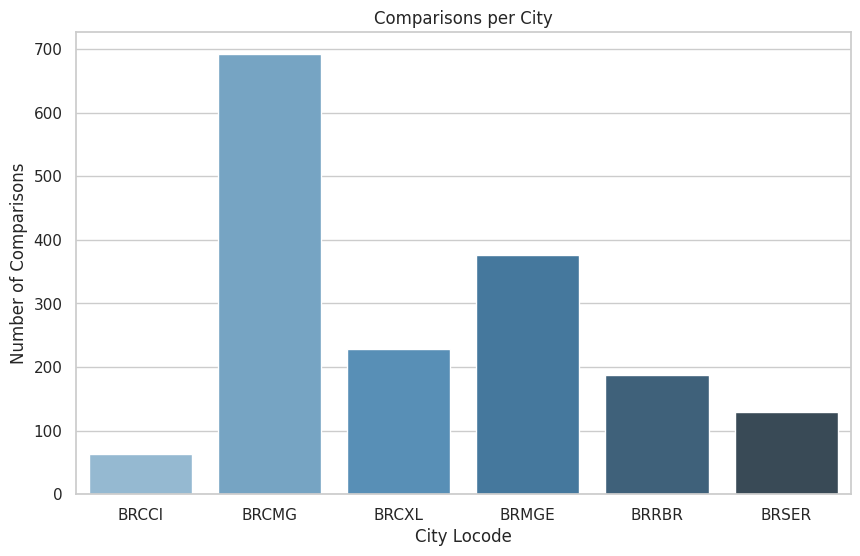

/tmp/ipython-input-2682281108.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_actions_series.index, y=unique_actions_series.values, palette="Greens_d")


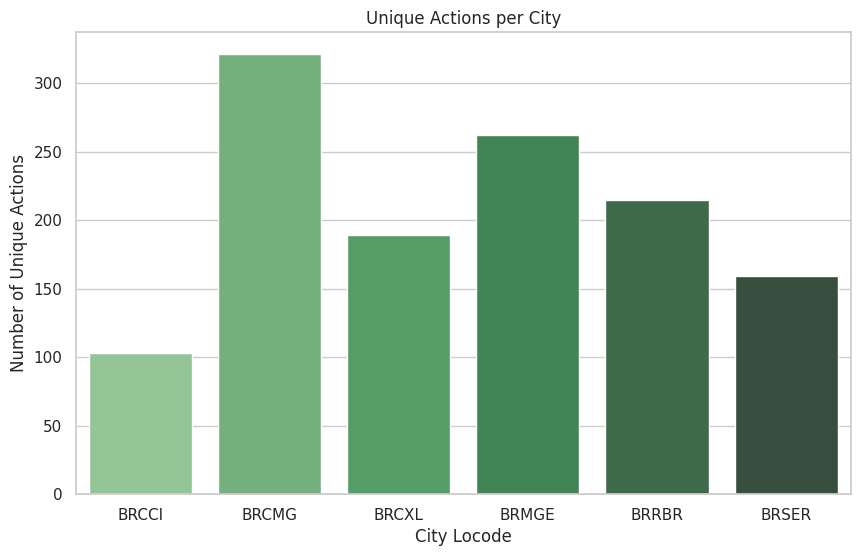

/tmp/ipython-input-2682281108.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_data, x="PreferredAction", y="WinCount", palette="coolwarm")


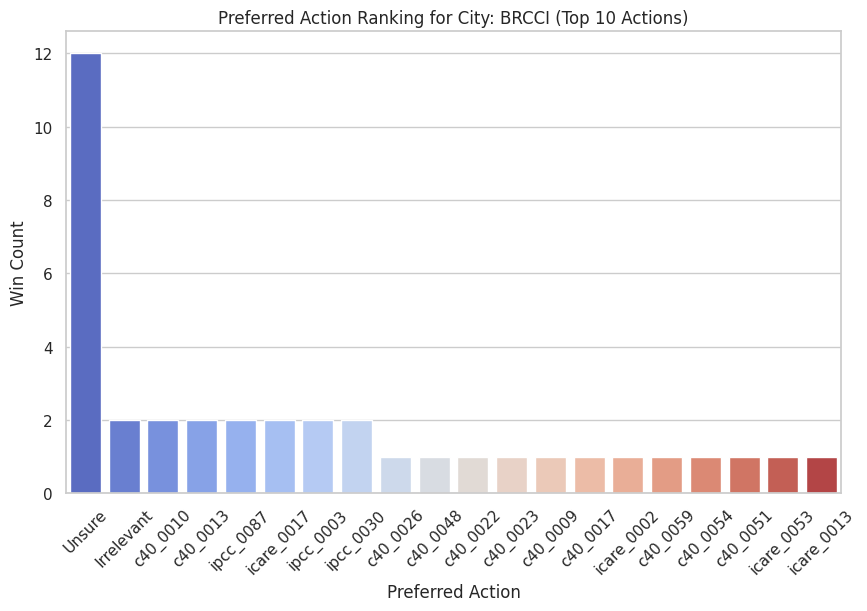

/tmp/ipython-input-2682281108.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_data, x="PreferredAction", y="WinCount", palette="coolwarm")


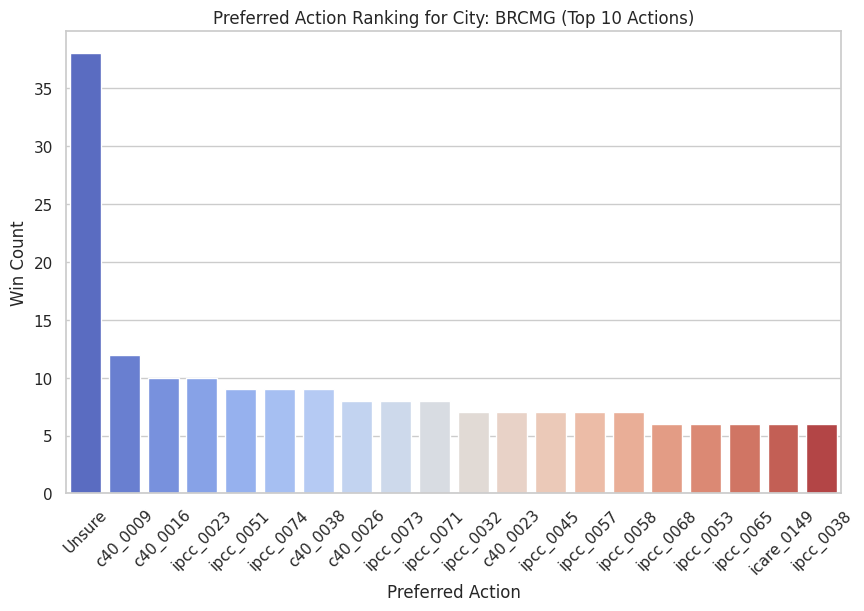

/tmp/ipython-input-2682281108.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_data, x="PreferredAction", y="WinCount", palette="coolwarm")


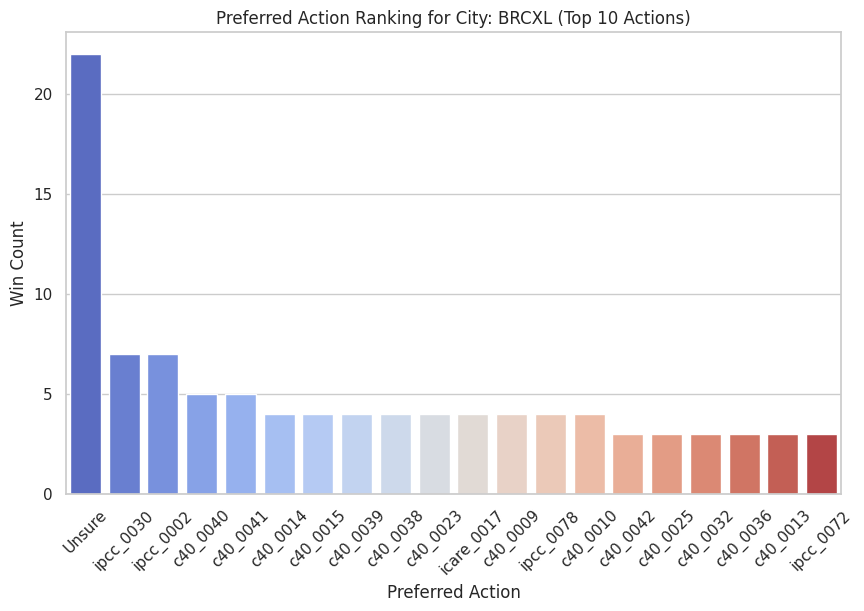

/tmp/ipython-input-2682281108.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_data, x="PreferredAction", y="WinCount", palette="coolwarm")


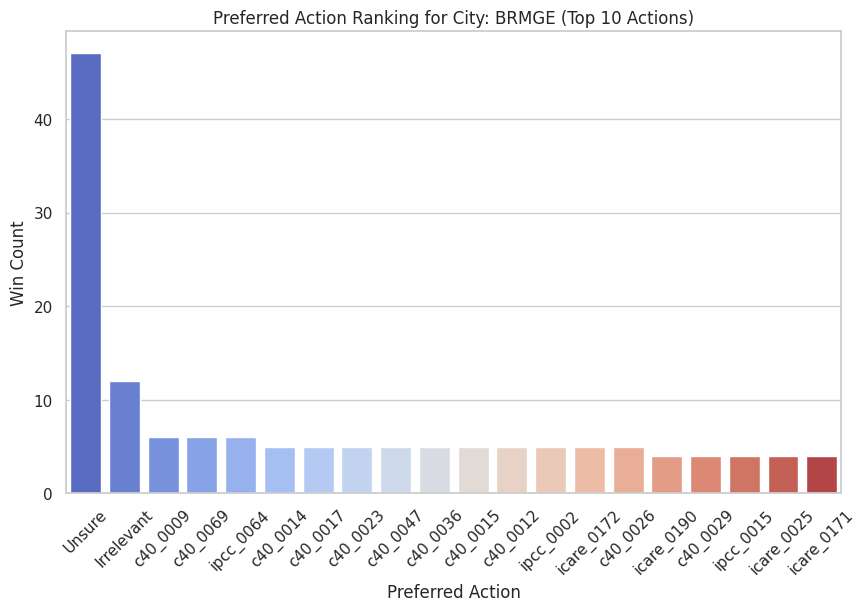

/tmp/ipython-input-2682281108.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_data, x="PreferredAction", y="WinCount", palette="coolwarm")


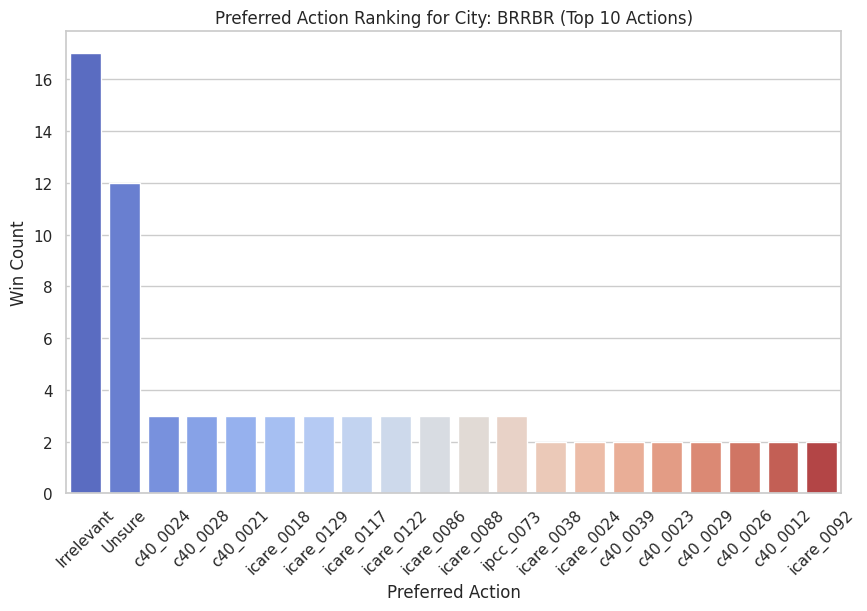

/tmp/ipython-input-2682281108.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_data, x="PreferredAction", y="WinCount", palette="coolwarm")


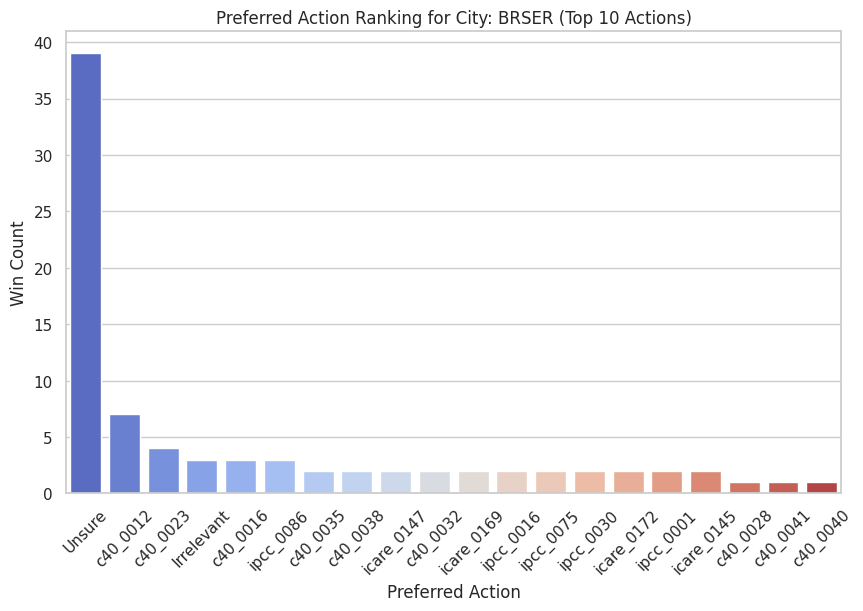

In [ ]:
# Create enhanced visualizations
visualize_eda(df_all_comparisons)

In [ ]:
df_all_comparisons

,SessionID,CityLocode,ActionA,ActionB,PreferredAction,note
0,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0074,c40_0032,ipcc_0074,NaN
1,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0016,ipcc_0034,ipcc_0034,NaN
2,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0036,ipcc_0002,ipcc_0002,NaN
3,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0028,ipcc_0042,ipcc_0028,NaN
4,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,c40_0021,ipcc_0030,c40_0021,NaN
...,...,...,...,...,...,...
1674,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,c40_0056,c40_0047,Unsure,NaN
1675,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,icare_0160,c40_0047,c40_0047,NaN
1676,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,icare_0140,icare_0145,icare_0145,NaN
1677,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,icare_0190,c40_0050,icare_0190,NaN


In [ ]:
# Check for inconsistencies in the preferred action outcome for the same action pair per city
check_inconsistencies(df_all_comparisons)


=== Checking for Inconsistencies in Preferred Actions ===

Inconsistencies found in 8 city/pair combination(s):

City: BRCMG, Action Pair: ('c40_0009', 'ipcc_0034')

City: BRCMG, Action Pair: ('c40_0009', 'ipcc_0080')

City: BRCMG, Action Pair: ('c40_0011', 'ipcc_0038')

City: BRCMG, Action Pair: ('c40_0014', 'c40_0031')

City: BRCMG, Action Pair: ('c40_0037', 'ipcc_0076')

City: BRCMG, Action Pair: ('icare_0018', 'ipcc_0008')

City: BRMGE, Action Pair: ('c40_0011', 'c40_0028')

City: BRMGE, Action Pair: ('ipcc_0030', 'ipcc_0064')


([(('BRCMG', ('c40_0009', 'ipcc_0034')),
                                    SessionID CityLocode    ActionA   ActionB  \
   52    226a4dd0-e38e-4e6e-aafa-5c8074086c7a      BRCMG  ipcc_0034  c40_0009   
   1254  226a4dd0-e38e-4e6e-aafa-5c8074086c7a      BRCMG  ipcc_0034  c40_0009   
   1570  33332c30-28ae-412c-9de4-36c9f0baed86      BRCMG  ipcc_0034  c40_0009   
   
        PreferredAction note               pair_key  
   52         ipcc_0034  NaN  (c40_0009, ipcc_0034)  
   1254       ipcc_0034  NaN  (c40_0009, ipcc_0034)  
   1570        c40_0009  NaN  (c40_0009, ipcc_0034)  ),
  (('BRCMG', ('c40_0009', 'ipcc_0080')),
                                    SessionID CityLocode    ActionA   ActionB  \
   71    226a4dd0-e38e-4e6e-aafa-5c8074086c7a      BRCMG  ipcc_0080  c40_0009   
   712   df64ea11-38cb-456d-8dce-c67f5ba3f205      BRCMG  ipcc_0080  c40_0009   
   1273  226a4dd0-e38e-4e6e-aafa-5c8074086c7a      BRCMG  ipcc_0080  c40_0009   
   
        PreferredAction note               p

In [ ]:
check_inconsistencies_and_percentage(df_all_comparisons)


=== Checking for Inconsistencies in Preferred Actions ===
Total pairs with multiple rankings: 121
Inconsistent pairs: 8
Percentage of inconsistent pairs: 6.61%


([(('BRCMG', ('c40_0009', 'ipcc_0034')),
                                    SessionID CityLocode    ActionA   ActionB  \
   52    226a4dd0-e38e-4e6e-aafa-5c8074086c7a      BRCMG  ipcc_0034  c40_0009   
   1254  226a4dd0-e38e-4e6e-aafa-5c8074086c7a      BRCMG  ipcc_0034  c40_0009   
   1570  33332c30-28ae-412c-9de4-36c9f0baed86      BRCMG  ipcc_0034  c40_0009   
   
        PreferredAction note               pair_key  
   52         ipcc_0034  NaN  (c40_0009, ipcc_0034)  
   1254       ipcc_0034  NaN  (c40_0009, ipcc_0034)  
   1570        c40_0009  NaN  (c40_0009, ipcc_0034)  ),
  (('BRCMG', ('c40_0009', 'ipcc_0080')),
                                    SessionID CityLocode    ActionA   ActionB  \
   71    226a4dd0-e38e-4e6e-aafa-5c8074086c7a      BRCMG  ipcc_0080  c40_0009   
   712   df64ea11-38cb-456d-8dce-c67f5ba3f205      BRCMG  ipcc_0080  c40_0009   
   1273  226a4dd0-e38e-4e6e-aafa-5c8074086c7a      BRCMG  ipcc_0080  c40_0009   
   
        PreferredAction note               p

In [ ]:
# Check for duplicates
check_duplicates(df_all_comparisons)

Rows with duplicate city action pair and same preferred action:
                                 SessionID CityLocode    ActionA    ActionB  \
0     226a4dd0-e38e-4e6e-aafa-5c8074086c7a      BRCMG  ipcc_0074   c40_0032   
1     226a4dd0-e38e-4e6e-aafa-5c8074086c7a      BRCMG  ipcc_0016  ipcc_0034   
2     226a4dd0-e38e-4e6e-aafa-5c8074086c7a      BRCMG  ipcc_0036  ipcc_0002   
3     226a4dd0-e38e-4e6e-aafa-5c8074086c7a      BRCMG  ipcc_0028  ipcc_0042   
4     226a4dd0-e38e-4e6e-aafa-5c8074086c7a      BRCMG   c40_0021  ipcc_0030   
...                                    ...        ...        ...        ...   
1565  33332c30-28ae-412c-9de4-36c9f0baed86      BRCMG  ipcc_0002   c40_0009   
1607  33332c30-28ae-412c-9de4-36c9f0baed86      BRMGE   c40_0026   c40_0018   
1610  33332c30-28ae-412c-9de4-36c9f0baed86      BRMGE   c40_0015   c40_0009   
1649  33332c30-28ae-412c-9de4-36c9f0baed86      BRCMG   c40_0009  ipcc_0002   
1678  33332c30-28ae-412c-9de4-36c9f0baed86      BRCMG   c40_0048   

,SessionID,CityLocode,ActionA,ActionB,PreferredAction,note,ContextPair
0,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0074,c40_0032,ipcc_0074,NaN,"(BRCMG, ipcc_0074, (c40_0032, ipcc_0074))"
1,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0016,ipcc_0034,ipcc_0034,NaN,"(BRCMG, ipcc_0034, (ipcc_0016, ipcc_0034))"
2,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0036,ipcc_0002,ipcc_0002,NaN,"(BRCMG, ipcc_0002, (ipcc_0002, ipcc_0036))"
3,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0028,ipcc_0042,ipcc_0028,NaN,"(BRCMG, ipcc_0028, (ipcc_0028, ipcc_0042))"
4,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,c40_0021,ipcc_0030,c40_0021,NaN,"(BRCMG, c40_0021, (c40_0021, ipcc_0030))"
...,...,...,...,...,...,...,...
1565,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,ipcc_0002,c40_0009,ipcc_0002,NaN,"(BRCMG, ipcc_0002, (c40_0009, ipcc_0002))"
1607,33332c30-28ae-412c-9de4-36c9f0baed86,BRMGE,c40_0026,c40_0018,c40_0026,NaN,"(BRMGE, c40_0026, (c40_0018, c40_0026))"
1610,33332c30-28ae-412c-9de4-36c9f0baed86,BRMGE,c40_0015,c40_0009,c40_0015,NaN,"(BRMGE, c40_0015, (c40_0009, c40_0015))"
1649,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,c40_0009,ipcc_0002,ipcc_0002,NaN,"(BRCMG, ipcc_0002, (c40_0009, ipcc_0002))"


Print out the dataframe for checking format:

In [ ]:
df_all_comparisons

,SessionID,CityLocode,ActionA,ActionB,PreferredAction,note
0,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0074,c40_0032,ipcc_0074,NaN
1,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0016,ipcc_0034,ipcc_0034,NaN
2,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0036,ipcc_0002,ipcc_0002,NaN
3,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0028,ipcc_0042,ipcc_0028,NaN
4,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,c40_0021,ipcc_0030,c40_0021,NaN
...,...,...,...,...,...,...
1674,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,c40_0056,c40_0047,Unsure,NaN
1675,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,icare_0160,c40_0047,c40_0047,NaN
1676,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,icare_0140,icare_0145,icare_0145,NaN
1677,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,icare_0190,c40_0050,icare_0190,NaN


### Drop rows

* First we drop all `Irrelevant` columns and optionally all unsure columns.
* (Optional) Then we drop duplicates (e.g. same action pair for the same city and same preferred action)
* Then we drop iconsistent comparisions (e.g. same action pair for the same city and different preferred action)

In [ ]:
def remove_irrelevant_rows(df, remove_unsure: bool) -> pd.DataFrame:
    """
    Removes rows where the 'PreferredAction' is 'Irrelevant'.
    If remove_unsure is True, also removes rows where the 'PreferredAction' is 'Unsure'.
    """

    df_cleaned = df[df['PreferredAction'] != "Irrelevant"]
    if remove_unsure:
        df_cleaned = df_cleaned[df_cleaned['PreferredAction'] != "Unsure"]

    return df_cleaned

In [ ]:
df_all_comparisons_cleaned = remove_irrelevant_rows(df_all_comparisons, remove_unsure=remove_unsure)

### (Optional) Remove duplicate entries

Different experts can label the same action with the same result. As this will not introduce any new information if the label is exactly the same, we will remove those duplicates.

Alternatively, we could add them in a way for higher confidence (e.g. if multiple experts rank the same action we are more confident about it). Currently however we trust the expert labeling to a 100% and therefore one label is enough.

If we have conflicting labels, we can later implement a majority vote or similar.

In [ ]:
def drop_duplicates_order_insensitive(df):
    """
    Returns a copy of the DataFrame with duplicates removed based on:
      - 'CityLocode'
      - 'PreferredAction'
      - An order-insensitive combination of 'ActionA' and 'ActionB'

    This function creates a temporary column for the normalized action pair,
    uses it to drop duplicates, and then removes the temporary column before returning.

    Prints the number of duplicate rows removed.
    """
    # Create a copy of the DataFrame so the original remains unmodified.
    df_temp = df.copy()

    # Create a temporary column 'temp_pair' that contains a sorted tuple of (ActionA, ActionB)
    df_temp["temp_pair"] = df_temp.apply(
        lambda row: tuple(sorted([row["ActionA"], row["ActionB"]])),
        axis=1
    )

    # Count duplicates before dropping
    initial_count = len(df_temp)

    # Drop duplicates based on 'CityLocode', 'temp_pair', and 'PreferredAction'
    df_temp = df_temp.drop_duplicates(subset=['CityLocode', 'temp_pair', 'PreferredAction'])

    # Count how many rows were removed
    removed_count = initial_count - len(df_temp)

    # Remove the temporary column
    df_temp = df_temp.drop(columns=["temp_pair"])

    # Print the number of removed duplicates
    print(f"\nRemoved {removed_count} duplicate row(s) based on 'CityLocode', 'PreferredAction', and an order-insensitive action pair.")

    return df_temp


In [ ]:
# Delete rows that are identical for a given city (action order invariant)
if remove_duplicates:
    df_all_comparisons_cleaned = drop_duplicates_order_insensitive(df_all_comparisons_cleaned)

### (Optional) Remove inconsisten rows

Contradictions are rare and they reflect real-world ambiguity by different opinions of experts. Therefore they can be kept to make the model more robust.

In [ ]:
def remove_inconsistent_rows(df):
    """
    Uses the check_inconsistencies function to find inconsistent rows,
    then removes those rows from the DataFrame and returns a cleaned copy.

    An inconsistency is defined as: within the same CityLocode and the same
    normalized action pair (order-insensitive), there are conflicting PreferredAction labels.
    """
    # Get the inconsistent groups from the check_inconsistencies function.
    # This function returns a list of tuples: ((CityLocode, normalized_action_pair), group)
    inconsistent_groups, count_inconsistencies = check_inconsistencies(df)

    # Create a set to hold all indices of rows that are part of any inconsistent group.
    indices_to_remove = set()

    for (city, pair), group in inconsistent_groups:
        # Add the indices of the group to the set
        indices_to_remove.update(group.index.tolist())

    # Create a new DataFrame that drops all rows with indices in indices_to_remove.
    df_clean = df.drop(index=indices_to_remove)

    # Optionally, print how many rows were removed.
    print(f"\nRemoved {len(indices_to_remove)} inconsistent row(s).")

    return df_clean

In [ ]:
# Delete inconsistent rows
if remove_inconsistencies:
    df_all_comparisons_cleaned = remove_inconsistent_rows(df_all_comparisons_cleaned)

Dataframe after insonsistent rows and duplicated comparisions have been removed:

In [ ]:
df_all_comparisons_cleaned

,SessionID,CityLocode,ActionA,ActionB,PreferredAction,note
0,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0074,c40_0032,ipcc_0074,NaN
1,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0016,ipcc_0034,ipcc_0034,NaN
2,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0036,ipcc_0002,ipcc_0002,NaN
3,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,ipcc_0028,ipcc_0042,ipcc_0028,NaN
4,226a4dd0-e38e-4e6e-aafa-5c8074086c7a,BRCMG,c40_0021,ipcc_0030,c40_0021,NaN
...,...,...,...,...,...,...
1673,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,c40_0056,icare_0171,c40_0056,NaN
1675,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,icare_0160,c40_0047,c40_0047,NaN
1676,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,icare_0140,icare_0145,icare_0145,NaN
1677,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,icare_0190,c40_0050,icare_0190,NaN


## Agment the data

We are mirroring the actions so that A vs B is as often as B vs A



In [ ]:
import pandas as pd

def mirror_comparisons(df: pd.DataFrame) -> pd.DataFrame:
    """
    Augments a pairwise comparisons DataFrame by mirroring the rows when the target
    is the actual action label (PreferredAction) that does not change when actions are swapped.

    Assumes the following columns exist:
      - 'SessionID'
      - 'CityLocode'
      - 'ActionA'
      - 'ActionB'
      - 'PreferredAction'
      - other columns (e.g., 'note')

    In the mirrored rows:
      - ActionA and ActionB are swapped.
      - PreferredAction remains the same.

    Returns:
      pd.DataFrame: Augmented DataFrame containing both original and mirrored rows.
    """
    df_mirrored = df.copy()

    # Swap ActionA and ActionB
    df_mirrored['ActionA'] = df['ActionB']
    df_mirrored['ActionB'] = df['ActionA']

    # PreferredAction remains unchanged

    # Optionally, add a flag for mirrored rows
    # df['mirrored'] = False
    # df_mirrored['mirrored'] = True

    # Concatenate the original and mirrored DataFrames
    df_augmented = pd.concat([df, df_mirrored], ignore_index=True)

    return df_augmented


In [ ]:
df_augmented = mirror_comparisons(df_all_comparisons_cleaned)
print(df_augmented.iloc[1469])
print(df_augmented.iloc[-2])

SessionID          33332c30-28ae-412c-9de4-36c9f0baed86
CityLocode                                        BRCMG
ActionA                                      icare_0190
ActionB                                        c40_0050
PreferredAction                              icare_0190
note                                                NaN
Name: 1469, dtype: object
SessionID          33332c30-28ae-412c-9de4-36c9f0baed86
CityLocode                                        BRCMG
ActionA                                        c40_0050
ActionB                                      icare_0190
PreferredAction                              icare_0190
note                                                NaN
Name: 2940, dtype: object


## Make train test split after removing rows

In [ ]:
from sklearn.model_selection import train_test_split

# Train-test split on the entire dataframe
df_train_split, df_test_split = train_test_split(
    df_augmented,
    test_size=0.2,
    random_state=42,
    shuffle=True
)


In [ ]:
# Save train and test splits to CSV files
df_train_split.to_csv("/content/df_train_split.csv", index=False)
df_test_split.to_csv("/content/df_test_split.csv", index=False)

In [ ]:
df_train_split.index

Index([ 462, 2176, 2671,  381,  847, 1990,  790, 1730, 1317,  798,
       ...
       1482,  330, 1238,  466, 2169, 1638, 1095, 1130, 1294,  860],
      dtype='int64', length=2353)

## Enrich DF with city and action data (executed in pipeline)

In this step the locodes of the cities and the action IDs are being swapped against there actual data.

df_merged contains:
- The original SessionID, PreferredAction, note, etc.
- All of the city details (with columns prefixed by "city_")
- All of the ActionA details (with columns prefixed by "ActionA_")
- All of the ActionB details (with columns prefixed by "ActionB_")
Any nested objects (such as the dictionaries inside socioEconomicFactors or CoBenefits) remain as objects in the DataFrame.

Load the reference files to swap in the actual data:

In [ ]:
import pandas as pd
import json
from pathlib import Path

def enrich_df_with_city_and_action_data(df: pd.DataFrame, path_city_data: Path, path_action_data: Path):
    """
    This function takes the original df with expert comparisons and enriches it with the
    actual city data and action data. If either ActionA or ActionB is missing in action_data,
    the entire row will be skipped.

    Returns:
    - df_enriched (pd.DataFrame): Enriched DataFrame with valid actions only.
    - missing_action_ids (set): Set of action IDs that were missing.
    """

    # Load city data
    with open(path_city_data, 'r', encoding='utf-8') as f:
        city_data = json.load(f)

    # Load action data
    with open(path_action_data, 'r', encoding='utf-8') as f:
        action_data = json.load(f)

    # Prepare the City DataFrame with Prefix
    df_city = pd.DataFrame(city_data).add_prefix("city_")

    # Merge city data FIRST
    df_enriched = df.merge(df_city, left_on="CityLocode", right_on="city_locode", how="left")
    df_enriched.drop(columns=["CityLocode"], inplace=True)

    # Convert action_data to a DataFrame
    df_action = pd.DataFrame(action_data)

    # Prepare action data with prefixes
    df_actionA = df_action.add_prefix("actionA_")
    df_actionB = df_action.add_prefix("actionB_")

    # Merge action data
    df_enriched = df_enriched.merge(df_actionA, left_on="ActionA", right_on="actionA_ActionID", how="left")
    df_enriched = df_enriched.merge(df_actionB, left_on="ActionB", right_on="actionB_ActionID", how="left")

    # Identify missing ActionA and ActionB
    missing_actionA = df_enriched[df_enriched["actionA_ActionID"].isna()]["ActionA"].unique()
    missing_actionB = df_enriched[df_enriched["actionB_ActionID"].isna()]["ActionB"].unique()

    # Combine into a set of unique missing action IDs
    missing_action_ids = set(missing_actionA) | set(missing_actionB)

    if missing_action_ids:
        print(f"Warning: The following Action IDs were not found in action_data and will be skipped:\n{missing_action_ids}")

    # Remove rows where either ActionA or ActionB is missing
    df_enriched = df_enriched.dropna(subset=["actionA_ActionID", "actionB_ActionID"])

    return df_enriched


In [ ]:
# from collections import Counter
# import ast

# def parse_list_safely(val):
#     if isinstance(val, list):
#         return val
#     elif isinstance(val, str):
#         try:
#             return ast.literal_eval(val)
#         except:
#             return []
#     return []

# def count_action_types(row):
#     counts = Counter()
#     for col in ['actionA_ActionType', 'actionB_ActionType']:
#         action_types = parse_list_safely(row.get(col))
#         for action_type in action_types:
#             if action_type in ['mitigation', 'adaptation']:
#                 counts[action_type] += 1
#     return counts

# # Aggregate across the dataframe
# total_counts = Counter()
# for _, row in df_enriched.iterrows():
#     total_counts += count_action_types(row)

# # Print results
# print("Action Type Counts:")
# for action_type, count in total_counts.items():
#     print(f"{action_type}: {count}")


Examine the final result

In [ ]:
# import pandas as pd
# import ast
# from collections import Counter

# def parse_dict_safely(val):
#     if isinstance(val, dict):
#         return val
#     elif isinstance(val, str):
#         try:
#             return ast.literal_eval(val)
#         except:
#             return {}
#     return {}

# def count_non_null_ghg_sectors(row):
#     counts = Counter()
#     for col in ['actionA_GHGReductionPotential', 'actionB_GHGReductionPotential']:
#         ghg_dict = parse_dict_safely(row.get(col))
#         for sector, val in ghg_dict.items():
#             if val not in [None, 'None', '', 'null']:  # catch more cases
#                 counts[sector] += 1
#     return counts

# # Apply to the full DataFrame
# total_counts = Counter()
# for _, row in df_enriched.iterrows():
#     total_counts += count_non_null_ghg_sectors(row)

# # Print results
# print("GHG Sector Usage Counts:")
# for sector, count in total_counts.items():
#     print(f"{sector}: {count}")


In [ ]:
# df_enriched.T

The actions are split between mitigatin and adaptation actions as follow:

In [ ]:
# num_mitigation_actionA = df_enriched['actionA_ActionType'].apply(lambda x: 'mitigation' in x if isinstance(x, list) else False).sum()
# num_mitigation_actionB = df_enriched['actionB_ActionType'].apply(lambda x: 'mitigation' in x if isinstance(x, list) else False).sum()
# num_adaptation_actionA = df_enriched['actionA_ActionType'].apply(lambda x: 'adaptation' in x if isinstance(x, list) else False).sum()
# num_adaptation_actionB = df_enriched['actionB_ActionType'].apply(lambda x: 'adaptation' in x if isinstance(x, list) else False).sum()

# print(f"Number of mitigation actions in ActionA: {num_mitigation_actionA}")
# print(f"Number of mitigation actions in ActionB: {num_mitigation_actionB}")
# print(f"Number of adaptation actions in ActionA: {num_adaptation_actionA}")
# print(f"Number of adaptation actions in ActionB: {num_adaptation_actionB}")

The following inspects if only adaptation actions have been measured against adaptation actions and mitigation actions against mitigation actions.
The result should be an empty dataframe (no mismatches)

In [ ]:
# mismatches = df_enriched[["actionA_ActionType", "actionB_ActionType"]].query("actionA_ActionType != actionB_ActionType")
# mismatches

### (Optional) Delete adaptation actions

Since adaptation and mitigation actions have different features that they are compared on, (e.g. GHG emission reduction vs. hazards) it might make sense to train 2 classifiers, one for each category.

However then in the ranking in needs to be guranteed that we only compare mitigation vs mitigation and adaptation vs. adaptation. This should be doable since in the end we create a list of top mitigation actions and one list of top adaptation actions (not a combined, mixed list).

In [ ]:
def remove_adaptation_actions(df) -> pd.DataFrame:

    # Remove rows where either column contains "adaptation" inside the list
    df_enriched = df[
        ~df["actionA_ActionType"].apply(lambda x: "adaptation" in x if isinstance(x, list) else False) &
        ~df["actionB_ActionType"].apply(lambda x: "adaptation" in x if isinstance(x, list) else False)
    ]
    return df_enriched

In [ ]:
# if remove_adaptation_actions_flag:
#     print(df_enriched.shape)
#     df_enriched = remove_adaptation_actions(df_enriched)
#     print(df_enriched.shape)

### (Optional) Delete mitigation actions

Since adaptation and mitigation actions have different features that they are compared on, (e.g. GHG emission reduction vs. hazards) it might make sense to train 2 classifiers, one for each category.

However then in the ranking in needs to be guranteed that we only compare mitigation vs mitigation and adaptation vs. adaptation. This should be doable since in the end we create a list of top mitigation actions and one list of top adaptation actions (not a combined, mixed list).

In [ ]:
def remove_mitigation_actions(df) -> pd.DataFrame:

    # Remove rows where either column contains "mitigation" inside the list
    df_enriched = df[
        ~df["actionA_ActionType"].apply(lambda x: "mitigation" in x if isinstance(x, list) else False) &
        ~df["actionB_ActionType"].apply(lambda x: "mitigation" in x if isinstance(x, list) else False)
    ]
    return df_enriched

In [ ]:
# if remove_mitigation_actions_flag:
#     print(df_enriched.shape)
#     df_enriched = remove_mitigation_actions(df_enriched)
#     print(df_enriched.shape)

Finally we remove all columns from the enriched dataframe that are not relevant for scoring like `SessionID`. Ohter columns might need to be revisited.
Since we only have limited training data, removing columns is advised.

In [ ]:
# df_enriched = df_enriched.drop(columns=["SessionID", "note", "city_locode", "city_name", "city_region", "city_regionName", "city_area", "city_socioEconomicFactors", "city_accessToPublicServices", "city_totalEmissions", "city_scope1Emissions", "city_scope2Emissions", "city_scope3Emissions", "actionA_ActionID", "actionA_ActionName", "actionA_Sector", "actionA_Subsector", "actionA_PrimaryPurpose", "actionA_Description", "actionA_EquityAndInclusionConsiderations", "actionA_Dependencies", "actionA_KeyPerformanceIndicators", "actionA_PowersAndMandates", "actionB_ActionID", "actionB_ActionName", "actionB_Sector", "actionB_Subsector", "actionB_PrimaryPurpose", "actionB_Description", "actionB_EquityAndInclusionConsiderations", "actionB_Dependencies", "actionB_KeyPerformanceIndicators", "actionB_PowersAndMandates"])

In [ ]:
# df_enriched.columns

In [ ]:
# df_enriched.T

## Feature Engineering

In this section we define the target value `y` and the features `X`.

### Convert PreferredAction to Class Labels

For binary:

1 → Action A is preferred

-1 → Action B is preferred

As both actions are equally favored (there is no target class), we spread them equally around 0

For multiclass:

0 → Action A is preferred

1 → Unsure

2 → Action B is preferred


In [ ]:
def convert_preferred_action_to_binary_labels(df):
    """
    Converts the PreferredAction column into binary labels.
    - 1 if PreferredAction is ActionA
    - 0 if PreferredAction is ActionB
    """
    df_copy = df.copy()  # Avoid modifying the original dataframe
    df_copy['y'] = df_copy.apply(
        lambda row: 1 if row['PreferredAction'] == row['ActionA'] else
                    0 if row['PreferredAction'] == row['ActionB'] else None,
        axis=1
    )

    # Optional: Drop rows where PreferredAction is neither ActionA nor ActionB
    # df_copy = df_copy[df_copy['y'].isin([0, 1])]

    df_copy = df_copy.drop(columns=["PreferredAction"])

    return df_copy


In [ ]:
# def convert_preferred_action_to_binary_labels(df):
#     """
#     Converts the PreferredAction column into binary labels.
#     - 1 if PreferredAction is ActionA
#     - 0 if PreferredAction is ActionB
#     """
#     df_copy = df.copy()  # Avoid modifying the original dataframe
#     df_copy['y'] = df_copy.apply(
#         lambda row: 1 if row['PreferredAction'] == row['ActionA'] else
#                     -1 if row['PreferredAction'] == row['ActionB'] else None, #0 For small dataset 0 gives best restult with 83%
#         axis=1
#     )

#     # Optional: Drop rows where PreferredAction is neither ActionA nor ActionB
#     df_copy = df_copy.drop(columns=["PreferredAction"])

#     return df_copy

In [ ]:
def convert_preferred_action_to_multi_class_labels(df):
    """
    Converts PreferredAction into multi-class labels:
    - 0 if PreferredAction is ActionA
    - 2 if PreferredAction is ActionB
    - 1 if PreferredAction is Unsure
    """
    df_copy = df.copy()  # Prevent modifying original DataFrame

    df_copy['y'] = df_copy.apply(
        lambda row: 0 if row['PreferredAction'] == row['ActionA'] else
                    2 if row['PreferredAction'] == row['ActionB'] else
                    1 if row['PreferredAction'] == "unsure" else None,
        axis=1
    )

    # Optional: Drop rows where PreferredAction is neither A, B, nor unsure
    df_copy = df_copy.dropna(subset=['y'])

    return df_copy

# df_enriched = convert_preferred_action_to_multi_class_labels(df_enriched)


In [ ]:
# df_transformed = convert_preferred_action_to_binary_labels(df_enriched)

In [ ]:
# df_transformed.T

In [ ]:
# df_cleaned = df_enriched

In [ ]:
# X = ['ActionA', 'ActionB',
#      'actionA_Hazard', 'actionB_Hazard',
#      'actionA_ActionType', 'actionB_ActionType',
#      'actionA_CoBenefits', 'actionB_CoBenefits',
#      'actionA_GHGReductionPotential', 'actionB_GHGReductionPotential',
#      'actionA_CostInvestmentNeeded', 'actionB_CostInvestmentNeeded',
#      'actionA_TimelineForImplementation', 'actionB_TimelineForImplementation',
#      'actionA_AdaptationEffectiveness', 'actionB_AdaptationEffectiveness',
#      'city_populationSize', 'city_populationDensity',
#      'city_elevation', 'city_biome',
#      'city_stationaryEnergyEmissions', 'city_transportationEmissions', 'city_wasteEmissions', 'city_industrialProcessEmissions', 'city_landUseEmissions',
#      'city_ccra']

# y = ['y']

In [ ]:
# df_cleaned = df_enriched[X + y].copy()
# df_cleaned.T

### Improve emissions and GHG emission factors

In [ ]:
def prepare_emission_reduction_data_single_diff(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function calculates the total reduction in emissions for each action,
    normalizes it by the total city emissions, and returns the percentage reduction for each action,
    along with the difference in reduction percentages between Action A and Action B.

    For example:
    - If Action A reduces the city emissions by 35% and Action B by 20%,
      the difference (actionA - actionB) is 15 percentage points.

    This normalization makes the result independent of the absolute magnitude of city emissions.
    """

    # Create a local copy
    df_copy = df.copy()

    sector_mapping = {
        "stationary_energy": "city_stationaryEnergyEmissions",
        "transportation": "city_transportationEmissions",
        "waste": "city_wasteEmissions",
        "ippu": "city_industrialProcessEmissions",
        "afolu": "city_landUseEmissions"
    }

    # Function to extract reduction potential safely
    def extract_ghg_value(ghg_dict, sector):
        """Extract numeric GHG reduction percentage for a given sector."""
        if isinstance(ghg_dict, dict) and sector in ghg_dict:
            value = ghg_dict[sector]
            if isinstance(value, str) and "-" in value:  # Convert range "40-59" → 49.5
                low, high = map(float, value.split("-"))
                return (low + high) / 2
            elif isinstance(value, (int, float)):
                return value
        return 0

    # Calculate total city emissions by summing emissions from all sectors
    df_copy["total_city_emissions"] = df_copy[list(sector_mapping.values())].sum(axis=1)

    # For each action, calculate total absolute reduction and convert to a percentage reduction
    for action in ["actionA", "actionB"]:
        ghg_column = f"{action}_GHGReductionPotential"  # Column containing the reduction potential (dict)
        total_abs_reduction_col = f"{action}_Total_Reduction"
        df_copy[total_abs_reduction_col] = 0  # Initialize total reduction

        for sector, city_col in sector_mapping.items():
            if city_col in df_copy.columns:
                # Extract the GHG reduction percentage for the sector
                reduction_pct_col = f"{action}_GHGReduction_{sector}"
                df_copy[reduction_pct_col] = df_copy[ghg_column].apply(lambda x: extract_ghg_value(x, sector))
                # Compute the absolute reduction (in kg CO2 or relevant unit)
                abs_reduction_col = f"{action}_EmissionReduction_{sector}"
                df_copy[abs_reduction_col] = df_copy[reduction_pct_col] * df_copy[city_col] / 100
                # Accumulate the absolute reductions for the action
                df_copy[total_abs_reduction_col] += df_copy[abs_reduction_col]

        # Normalize to get percentage reduction relative to total city emissions
        percentage_reduction_col = f"{action}_Percentage_Reduction"
        df_copy[percentage_reduction_col] = (df_copy[total_abs_reduction_col] / df_copy["total_city_emissions"]) * 100

    # Compute the percentage difference between Action A and Action B
    df_copy["EmissionReduction_Percentage_Diff"] = (
        df_copy["actionA_Percentage_Reduction"] - df_copy["actionB_Percentage_Reduction"]
    )

    # Clean up intermediate columns while keeping the percentage reduction columns and final difference.
    intermediate_cols = []
    for action in ["actionA", "actionB"]:
        for sector in sector_mapping.keys():
            intermediate_cols.append(f"{action}_GHGReduction_{sector}")
            intermediate_cols.append(f"{action}_EmissionReduction_{sector}")
        intermediate_cols.append(f"{action}_Total_Reduction")
    # Also drop the original GHG Reduction Potential columns and city emissions columns if they are not needed.
    intermediate_cols += ["actionA_GHGReductionPotential", "actionB_GHGReductionPotential"] + list(sector_mapping.values())
    df_copy.drop(columns=intermediate_cols, inplace=True)

    return df_copy



In [ ]:
def prepare_emission_reduction_data_single_diff_old(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function combines the city emissions per sector and the GHG emission reduction potential into one overall
    column containing the absolute reduction difference between two actions.

    For example:
    - Action A has a 10% reduction potential for transportation on 1000 kg CO2 → reduction of 100 kg CO2.
    - Action B has a 20% reduction potential for transportation on 1000 kg CO2 → reduction of 200 kg CO2.
    The difference (actionA - actionB) is -100 kg CO2.

    The overall column 'EmissionReduction_Diff_total' will sum these differences across all sectors.
    A positive value indicates Action A has a higher overall reduction potential,
    a negative value indicates Action A has a lower overall reduction potential,
    and 0 means both actions have the same overall reduction.
    """

    # Create a local copy
    df_copy = df.copy()

    sector_mapping = {
        "stationary_energy": "city_stationaryEnergyEmissions",
        "transportation": "city_transportationEmissions",
        "waste": "city_wasteEmissions",
        "ippu": "city_industrialProcessEmissions",
        "afolu": "city_landUseEmissions"
    }

    # Function to extract reduction potential safely
    def extract_ghg_value(ghg_dict, sector):
        """Extract numeric GHG reduction percentage for a given sector."""
        if isinstance(ghg_dict, dict) and sector in ghg_dict:
            value = ghg_dict[sector]
            if isinstance(value, str) and "-" in value:  # Convert range "40-59" → 49.5
                low, high = map(float, value.split("-"))
                return (low + high) / 2
            elif isinstance(value, (int, float)):
                return value  # Use numeric values directly
        return 0  # Default to 0 if missing or null

    # Extract GHG Reduction values and compute absolute reductions
    for action in ["actionA", "actionB"]:
        ghg_column = f"{action}_GHGReductionPotential"  # This column contains the dictionary

        for sector, city_column in sector_mapping.items():
            if city_column in df_copy.columns:
                # Extract GHG reduction percentage
                df_copy[f"{action}_GHGReduction_{sector}"] = df_copy[ghg_column].apply(lambda x: extract_ghg_value(x, sector))
                # Compute absolute reduction impact
                df_copy[f"{action}_EmissionReduction_{sector}"] = (
                    df_copy[f"{action}_GHGReduction_{sector}"] * df_copy[city_column] / 100
                )

    # Compute differences in emission reductions between Action A and B for each sector
    for sector in sector_mapping.keys():
        df_copy[f"EmissionReduction_Diff_{sector}"] = (
            df_copy[f"actionA_EmissionReduction_{sector}"] - df_copy[f"actionB_EmissionReduction_{sector}"]
        )

    # Sum all individual sector differences to create one overall reduction difference column
    diff_columns = [f"EmissionReduction_Diff_{sector}" for sector in sector_mapping.keys()]
    df_copy["EmissionReduction_Diff_total"] = df_copy[diff_columns].sum(axis=1)

    # Drop the original GHG Reduction Potential columns (nested dictionaries)
    df_copy.drop(columns=["actionA_GHGReductionPotential", "actionB_GHGReductionPotential"], inplace=True)

    # Drop intermediate extracted GHG percentage columns
    drop_columns = [f"{action}_GHGReduction_{sector}"
                    for action in ["actionA", "actionB"]
                    for sector in sector_mapping.keys()]
    df_copy.drop(columns=drop_columns, inplace=True)

    # Drop intermediate computed emission reduction columns
    drop_columns = [f"{action}_EmissionReduction_{sector}"
                    for action in ["actionA", "actionB"]
                    for sector in sector_mapping.keys()]
    df_copy.drop(columns=drop_columns, inplace=True)

    # Drop the individual per-sector difference columns
    df_copy.drop(columns=diff_columns, inplace=True)

    # Optionally, drop the original city emissions columns if they are no longer needed
    df_copy.drop(columns=list(sector_mapping.values()), inplace=True)

    return df_copy

In [ ]:
def prepare_emission_reduction_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function combines the city emissions per sector and the GHG emission reduction potential into one column
    containing the absolute reduction difference between two actions.

    E.g.
    actionA has reduction potential of 10% for transportation
    actionB has reduction potential of 20% for transportation
    city has 1000 kg CO2 in transportation

    actionA reduces by 100 kg CO2
    actionB reduces by 200 kg CO2
    The difference is actionA - actionB = -100
    This will be in a dedicated column
    """

    # Create a local copy
    df_copy = df.copy()

    sector_mapping = {
        "stationary_energy": "city_stationaryEnergyEmissions",
        "transportation": "city_transportationEmissions",
        "waste": "city_wasteEmissions",
        "ippu": "city_industrialProcessEmissions",
        "afolu": "city_landUseEmissions"
    }

    # Function to extract reduction potential safely
    def extract_ghg_value(ghg_dict, sector):
        """Extract numeric GHG reduction percentage for a given sector."""
        if isinstance(ghg_dict, dict) and sector in ghg_dict:
            value = ghg_dict[sector]
            if isinstance(value, str) and "-" in value:  # Convert range "40-59" → 49.5
                low, high = map(float, value.split("-"))
                return (low + high) / 2
            elif isinstance(value, (int, float)):
                return value  # Use numeric values directly
        return 0  # Default to 0 if missing or null

    # Extract GHG Reduction values and compute absolute reductions
    for action in ["actionA", "actionB"]:
        ghg_column = f"{action}_GHGReductionPotential"  # This column contains the dictionary

        for sector, city_column in sector_mapping.items():  # Map GHG sector names to city emission names
            if city_column in df_copy.columns:  # Ensure the city emissions column exists

                # Extract GHG reduction percentage
                df_copy[f"{action}_GHGReduction_{sector}"] = df_copy[ghg_column].apply(lambda x: extract_ghg_value(x, sector))

                # Compute absolute reduction impact
                df_copy[f"{action}_EmissionReduction_{sector}"] = (
                    df_copy[f"{action}_GHGReduction_{sector}"] * df_copy[city_column] / 100
                )

    # Compute differences in emission reductions between Action A and B
    # A positive value means that action A has higher emissions reduction
    # A negative value means that action B has higher emissions reduction
    for sector in sector_mapping.keys():
        df_copy[f"EmissionReduction_Diff_{sector}"] = (
            df_copy[f"actionA_EmissionReduction_{sector}"] - df_copy[f"actionB_EmissionReduction_{sector}"]
        )

    # Drop the original GHG Reduction Potential columns (nested dictionaries)
    df_copy.drop(columns=["actionA_GHGReductionPotential", "actionB_GHGReductionPotential"], inplace=True)

    # Drop intermediate extracted GHG percentage columns
    drop_columns = [f"{action}_GHGReduction_{sector}" for action in ["actionA", "actionB"] for sector in sector_mapping.keys()]
    df_copy.drop(columns=drop_columns, inplace=True)
    drop_columns = [f"{action}_EmissionReduction_{sector}" for action in ["actionA", "actionB"] for sector in sector_mapping.keys()]
    df_copy.drop(columns=drop_columns, inplace=True)

    # Drop the original emissions columns (if they are not needed anymore)
    df_copy.drop(columns=list(sector_mapping.values()), inplace=True)

    return df_copy

### Transforming categorical values

#### ActionType

The following logic is being used:

actionA_mitigation → 1 if Action A includes "mitigation", else 0
actionA_adaptation → 1 if Action A includes "adaptation", else 0
actionB_mitigation → 1 if Action B includes "mitigation", else 0
actionB_adaptation → 1 if Action B includes "adaptation", else 0

This ensurs, that an action can have one or both flags as defined per schema.
Note: in our current data we do not have actions that are both.

In [ ]:
import pandas as pd

def prepare_action_type_data_binary(df) -> pd.DataFrame:
    # Create a local copy
    df_copy = df.copy()

    # Function to encode ActionType as a single binary value
    def encode_action_type(action_type_list):
        """Return 1 if the action is 'mitigation', otherwise 0."""
        if isinstance(action_type_list, list) and "mitigation" in action_type_list:
            return 1  # Mitigation
        return 0  # Adaptation (default)

    # Since both actions are always the same, just check one of them (e.g., actionA)
    df_copy["ActionType"] = df_copy["actionA_ActionType"].apply(encode_action_type).astype(int)

    # Drop original columns
    df_copy.drop(columns=["actionA_ActionType", "actionB_ActionType"], inplace=True)

    return df_copy


In [ ]:
def prepare_action_type_data(df) -> pd.DataFrame:

    # Create local copy
    df_copy = df.copy()

    # Function to one-hot encode ActionType lists
    def one_hot_encode_action_type(action_type_list, category):
        """Check if category exists in the list and return 1 or 0."""
        if isinstance(action_type_list, list):  # Ensure it's a list
            return 1 if category in action_type_list else 0
        return 0  # Default to 0 if missing

    # Apply encoding for both actions
    for action in ["actionA", "actionB"]:
        df_copy[f"{action}_mitigation"] = df_copy[f"{action}_ActionType"].apply(lambda x: one_hot_encode_action_type(x, "mitigation"))
        df_copy[f"{action}_adaptation"] = df_copy[f"{action}_ActionType"].apply(lambda x: one_hot_encode_action_type(x, "adaptation"))

    # Drop the original multi-label categorical columns
    df_copy.drop(columns=["actionA_ActionType", "actionB_ActionType"], inplace=True)

    return df_copy

#### CostInvestmentNeeded

First the categories gets mapped according to below:

Low → 2 (best, lowest cost)

Medium → 1

High → 0 (worst, highest cost)

Then we create the difference between both actions.
A positive value (e.g. 2) means that action A has higher score (meaning lower cost) than action B.
A negative value (e.g. -2) means that action A has a lower score (meaning higher cost) than action B.


In [ ]:
    def prepare_cost_investment_needed_data_old(df) -> pd.DataFrame:
        """
        This function maps the cost investment needed to a ranking.
        The higher the cost, the lower the ranking.

        If the cost investment needed is missing, it will be set to 0 (worst ranking) per default.
        """
        # Define cost ranking
        cost_mapping = {"low": 3, "medium": 2, "high": 1}

        # Apply mapping to both actionA and actionB with default value 0
        df["actionA_CostInvestmentNeeded"] = df["actionA_CostInvestmentNeeded"].map(
            lambda x: cost_mapping.get(x, 0)
        )
        df["actionB_CostInvestmentNeeded"] = df["actionB_CostInvestmentNeeded"].map(
            lambda x: cost_mapping.get(x, 0)
        )

        # Compute difference between both actions
        df["CostInvestmentNeeded_Diff"] = (
            df["actionA_CostInvestmentNeeded"] - df["actionB_CostInvestmentNeeded"]
        )

        # Drop the original columns
        df.drop(
            columns=["actionA_CostInvestmentNeeded", "actionB_CostInvestmentNeeded"],
            inplace=True,
        )

        return df

In [ ]:
def prepare_cost_investment_needed_data(df) -> pd.DataFrame:

    # Create local copy
    df_copy = df.copy()

    # Define cost ranking
    cost_mapping = {'low': 2, 'medium': 1, 'high': 0}

    # Apply mapping to both actionA and actionB
    df_copy['actionA_CostInvestmentNeeded'] = df_copy['actionA_CostInvestmentNeeded'].map(cost_mapping)
    df_copy['actionB_CostInvestmentNeeded'] = df_copy['actionB_CostInvestmentNeeded'].map(cost_mapping)

    # Compute difference between both actions
    df_copy['CostInvestmentNeeded_Diff'] = df_copy['actionA_CostInvestmentNeeded'] - df_copy['actionB_CostInvestmentNeeded']

    # Drop the original columns
    df_copy.drop(columns=['actionA_CostInvestmentNeeded', 'actionB_CostInvestmentNeeded'], inplace=True)

    return df_copy

#### Timeline for implementation



- <5 years → 2 (best, shortest implementation time)
- 5-10 years → 1
- \>10 years → 0 (worst, longest implementation time)

A positive value means that action A has a shorter implementation time.

A megatove value means that action B has a shorter implementatoin time.

In [ ]:
    def prepare_timeline_data_old(df) -> pd.DataFrame:
        # Define timeline ranking
        timeline_mapping = {"<5 years": 3, "5-10 years": 2, ">10 years": 1}

        # Apply mapping to both actionA and actionB with default value 0
        df["actionA_TimelineForImplementation"] = df[
            "actionA_TimelineForImplementation"
        ].map(lambda x: timeline_mapping.get(x, 0))
        df["actionB_TimelineForImplementation"] = df[
            "actionB_TimelineForImplementation"
        ].map(lambda x: timeline_mapping.get(x, 0))

        # Calculate the difference
        df["TimelineForImplementation_Diff"] = (
            df["actionA_TimelineForImplementation"]
            - df["actionB_TimelineForImplementation"]
        )

        # Drop old column
        df.drop(
            columns=[
                "actionA_TimelineForImplementation",
                "actionB_TimelineForImplementation",
            ],
            inplace=True,
        )

        return df

In [ ]:
def prepare_timeline_data(df) -> pd.DataFrame:

    # Create local copy
    df_copy = df.copy()

    # Define timeline ranking
    timeline_mapping = {'<5 years': 2, '5-10 years': 1, '>10 years': 0}

    # Apply mapping to both actionA and actionB
    df_copy['actionA_TimelineForImplementation'] = df_copy['actionA_TimelineForImplementation'].map(timeline_mapping)
    df_copy['actionB_TimelineForImplementation'] = df_copy['actionB_TimelineForImplementation'].map(timeline_mapping)

    # Calculate the difference
    df_copy['TimelineForImplementation_Diff'] = df_copy['actionA_TimelineForImplementation'] - df_copy['actionB_TimelineForImplementation']

    # Drop old column
    df_copy.drop(columns=['actionA_TimelineForImplementation', 'actionB_TimelineForImplementation'], inplace=True)

    return df_copy

#### CCRAs, hazards, and AdaptationEffectiveness

In this section we do the following:

We have the city risk assessment CCRAs. These give us per hazard a risk score of how affected a certain sector (e.g. infrastructure) is by a certain risk.

We have the hazards that a climate action adresses. This can be a list of multiple hazards.

We have an adaptation effectiveness that tells us, how well the action addresses the hazards. Here we also have a simplification in the data which is that we only have one adaptation effectiveness value for the entire list of hazards the action adresses.

Procedure:
Get the hihgest risk score per hazard of the city (we could take as well the average but we go with the max risk score for now)
* Match this with the hazards adressed by the action
* Create a sum over all the risk scores
* Multiply this by the adaptation effectiveness

The result is a value that is higher
* the more hazards match between action and city
* the higher the adaptation effectiveness of the city

Finally we create a difference column which substracts the value of actionA from the value of actionB

- \> 0 → Action A has better risk score.
- < 0 → Action B has better risk score.
- = 0 → Both actions have the same risk score (e.g. by adressing the same action with the same hazards or by adressing different hazards with same impact and effectiveness)

##### Adaptation Effectiveness

Our current data has a simplification, that 'AdaptionEffectiveness' counts for all hazards listed. Technically we would need one per hazard similar to GHG emission reduction.

We change the categorical values to numerical values like so:

* None -> 0
* 'low' -> 1
* 'medium' -> 2
* 'high' -> 3

In [ ]:
def prepare_adaptation_effectiveness_data(df) -> pd.DataFrame:

    # Create local copy
    df_copy = df.copy()

    # Define adaptation effectiveness ranking
    adaptation_mapping = {'low': 1, 'medium': 2, 'high': 3}

    # Apply mapping with proper handling for None or missing keys by returning 0
    df_copy['actionA_AdaptationEffectiveness'] = df_copy['actionA_AdaptationEffectiveness'].map(lambda x: adaptation_mapping.get(x, 0))
    df_copy['actionB_AdaptationEffectiveness'] = df_copy['actionB_AdaptationEffectiveness'].map(lambda x: adaptation_mapping.get(x, 0))

    return df_copy

In [ ]:
import pandas as pd

def prepare_adaptation_effectiveness_per_hazard_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts the adaptation effectiveness per hazard (e.g. 'high', 'medium', 'low')
    into numeric values for each action.
    """
    df_copy = df.copy()
    adaptation_mapping = {'low': 1, 'medium': 2, 'high': 3}

    def map_effectiveness_dict(eff_dict):
        if isinstance(eff_dict, dict):
            return {k: adaptation_mapping.get(v, 0) for k, v in eff_dict.items()}
        return {}

    if 'actionA_AdaptationEffectivenessPerHazard' in df_copy.columns:
        df_copy['actionA_AdaptationEffectivenessPerHazard'] = df_copy['actionA_AdaptationEffectivenessPerHazard'].apply(map_effectiveness_dict)
    else:
        print("Warning: 'actionA_AdaptationEffectivenessPerHazard' column not found.")

    if 'actionB_AdaptationEffectivenessPerHazard' in df_copy.columns:
        df_copy['actionB_AdaptationEffectivenessPerHazard'] = df_copy['actionB_AdaptationEffectivenessPerHazard'].apply(map_effectiveness_dict)
    else:
        print("Warning: 'actionB_AdaptationEffectivenessPerHazard' column not found.")

    return df_copy

##### CCRAs and hazards

In [ ]:
def prepare_city_risk_profile_per_hazard(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts the city's risk profile from 'city_ccra'.
    The risk profile is a dict mapping hazards to the maximum normalized risk score.
    """
    df_copy = df.copy()

    def extract_risk_profile(ccra_data):
        risk_profile = {}
        if isinstance(ccra_data, list):
            for entry in ccra_data:
                hazard = entry.get('hazard')
                score = entry.get('normalised_risk_score')
                if hazard is None or score is None:
                    continue
                # Keep the highest score for each hazard
                risk_profile[hazard] = max(risk_profile.get(hazard, 0), score)
        return risk_profile

    if 'city_ccra' in df_copy.columns:
        df_copy['city_risk_profile'] = df_copy['city_ccra'].apply(extract_risk_profile)
    else:
        print("Warning: 'city_ccra' column not found in DataFrame.")

    return df_copy

# MODIFIED FUNCTION: Now returns a dictionary of matching hazards instead of a list.
def match_action_hazards_with_city_risks_per_hazard(df: pd.DataFrame) -> pd.DataFrame:
    """
    Matches each action's list of hazards with the city's risk profile.
    Instead of returning a list of risk scores, this version returns a dictionary mapping
    each matching hazard to its risk score.
    """
    df_copy = df.copy()

    def get_matching_hazards(action_hazards, city_risk_profile):
        if not isinstance(action_hazards, list) or not isinstance(city_risk_profile, dict):
            return {}
        return {hazard: city_risk_profile[hazard] for hazard in action_hazards if hazard in city_risk_profile}

    if 'actionA_Hazard' in df_copy.columns:
        df_copy['actionA_matched_hazards'] = df_copy.apply(
            lambda row: get_matching_hazards(row.get('actionA_Hazard', []), row.get('city_risk_profile', {})),
            axis=1
        )
    else:
        print("Warning: 'actionA_Hazard' column not found.")

    if 'actionB_Hazard' in df_copy.columns:
        df_copy['actionB_matched_hazards'] = df_copy.apply(
            lambda row: get_matching_hazards(row.get('actionB_Hazard', []), row.get('city_risk_profile', {})),
            axis=1
        )
    else:
        print("Warning: 'actionB_Hazard' column not found.")

    return df_copy

# MODIFIED FUNCTION: Use the per-hazard effectiveness values.
def create_weighted_comparative_feature_per_hazard(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each action, compute a weighted total risk score:
      - For each matched hazard, multiply the city's risk score by the action's effectiveness score (from the per-hazard dictionary).
      - Sum these values to get the action's weighted risk total.
    Then compute the difference: (Action A total - Action B total).
    """
    df_copy = df.copy()

    def compute_weighted_total(matched_hazards, adaptation_dict):
        total = 0
        if isinstance(matched_hazards, dict) and isinstance(adaptation_dict, dict):
            for hazard, risk in matched_hazards.items():
                effectiveness = adaptation_dict.get(hazard, 0)
                total += risk * effectiveness
        return total

    df_copy['weighted_actionA_risk_total'] = df_copy.apply(
        lambda row: compute_weighted_total(
            row.get('actionA_matched_hazards', {}),
            row.get('actionA_AdaptationEffectivenessPerHazard', {})
        ),
        axis=1
    )

    df_copy['weighted_actionB_risk_total'] = df_copy.apply(
        lambda row: compute_weighted_total(
            row.get('actionB_matched_hazards', {}),
            row.get('actionB_AdaptationEffectivenessPerHazard', {})
        ),
        axis=1
    )

    df_copy['weighted_risk_score_Diff'] = df_copy['weighted_actionA_risk_total'] - df_copy['weighted_actionB_risk_total']

    return df_copy

In [ ]:
# MODIFIED PIPELINE FUNCTION: Incorporates the new per-hazard effectiveness processing.
def process_ccra_hazards_adaptation_effectiveness_per_hazard(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the DataFrame through the following steps:
      1. Extract the city's risk profile from 'city_ccra'.
      2. Convert each action's per-hazard adaptation effectiveness ratings to numeric values.
      3. Match the hazards from each action with the city's risk profile.
      4. Compute the weighted risk total for each action using the per-hazard values.
      5. Create the 'weighted_risk_score_Diff' feature.
    """
    df_processed = df.copy()
    df_processed = prepare_city_risk_profile_per_hazard(df_processed)
    df_processed = prepare_adaptation_effectiveness_per_hazard_data(df_processed)  # NEW CALL
    df_processed = match_action_hazards_with_city_risks_per_hazard(df_processed)
    df_processed = create_weighted_comparative_feature_per_hazard(df_processed)

    # Optionally, drop intermediate columns, leaving only the final comparative feature.
    columns_to_drop = [
        'actionA_AdaptationEffectivenessPerHazard',
        'actionB_AdaptationEffectivenessPerHazard',
        'actionA_matched_hazards',
        'actionB_matched_hazards',
        'city_risk_profile',
        'city_ccra',
        'actionA_Hazard',
        'actionB_Hazard',
        'weighted_actionA_risk_total',
        'weighted_actionB_risk_total'
    ]
    df_processed.drop(columns=columns_to_drop, inplace=True)
    return df_processed

In [ ]:
def prepare_city_risk_profile(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts a risk profile from the 'city_ccra' column and adds it as a new column 'city_risk_profile'.
    Each risk profile is a dictionary mapping hazards to the maximum normalized risk score.
    """
    df_copy = df.copy()

    def extract_risk_profile(ccra_data):
        risk_profile = {}
        # Ensure the data is a list of dictionaries
        if isinstance(ccra_data, list):
            for entry in ccra_data:
                hazard = entry.get('hazard')
                score = entry.get('normalised_risk_score')
                # Skip entries with missing hazard or score
                if hazard is None or score is None:
                    continue
                # Use the maximum score if a hazard appears multiple times
                risk_profile[hazard] = max(risk_profile.get(hazard, 0), score)
        return risk_profile

    if 'city_ccra' in df_copy.columns:
        df_copy['city_risk_profile'] = df_copy['city_ccra'].apply(extract_risk_profile)
    else:
        print("Warning: 'city_ccra' column not found in DataFrame.")

    return df_copy

def match_action_hazards_with_city_risks(df: pd.DataFrame) -> pd.DataFrame:
    """
    Matches each action's hazard list with the city's risk profile.
    Creates two new columns:
      - 'actionA_risk_scores': List of risk scores for hazards in 'actionA_Hazard' that are present in the city's risk profile.
      - 'actionB_risk_scores': List of risk scores for hazards in 'actionB_Hazard' that are present in the city's risk profile.
    """
    df_copy = df.copy()

    def get_matching_risk_scores(action_hazards, city_risk_profile):
        # Validate that we have the correct types
        if not isinstance(action_hazards, list) or not isinstance(city_risk_profile, dict):
            return []
        return [city_risk_profile[hazard] for hazard in action_hazards if hazard in city_risk_profile]

    # Process Action A hazards
    if 'actionA_Hazard' in df_copy.columns:
        df_copy['actionA_risk_scores'] = df_copy.apply(
            lambda row: get_matching_risk_scores(row.get('actionA_Hazard', []), row.get('city_risk_profile', {})),
            axis=1
        )
    else:
        print("Warning: 'actionA_Hazard' column not found.")

    # Process Action B hazards
    if 'actionB_Hazard' in df_copy.columns:
        df_copy['actionB_risk_scores'] = df_copy.apply(
            lambda row: get_matching_risk_scores(row.get('actionB_Hazard', []), row.get('city_risk_profile', {})),
            axis=1
        )
    else:
        print("Warning: 'actionB_Hazard' column not found.")

    return df_copy

def create_weighted_comparative_feature(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes a weighted total risk score for each action by:
      - Summing the matched risk scores from the corresponding action.
      - Multiplying the sum by the action's adaptation effectiveness.

    Creates the following new columns:
      - 'weighted_actionA_risk_total'
      - 'weighted_actionB_risk_total'
      - 'weighted_risk_score_diff': The difference (Action A total minus Action B total)

    A positive 'weighted_risk_score_diff' indicates that Action A is better aligned with the city's risks.
    """
    df_copy = df.copy()

    def sum_scores(scores):
        if isinstance(scores, list):
            return sum(scores)
        return 0

    # Calculate weighted risk total for Action A and Action B.
    # The adaptation effectiveness columns are assumed to be numeric (values between 1 and 3).
    df_copy['weighted_actionA_risk_total'] = (
        df_copy['actionA_risk_scores'].apply(sum_scores) *
        df_copy['actionA_AdaptationEffectiveness']
    )
    df_copy['weighted_actionB_risk_total'] = (
        df_copy['actionB_risk_scores'].apply(sum_scores) *
        df_copy['actionB_AdaptationEffectiveness']
    )

    # Compute the comparative feature.
    df_copy['weighted_risk_score_Diff'] = (
        df_copy['weighted_actionA_risk_total'] - df_copy['weighted_actionB_risk_total']
    )

    return df_copy

In [ ]:
def process_ccra_hazards_adaptation_effectiveness(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the input DataFrame through the following pipeline:
      1. Extract the city's risk profile from 'city_ccra'.
      2. Match each action's hazard list with the city's risk profile.
      3. Compute a weighted comparative feature based on the matched risk scores and adaptation effectiveness.

    Returns the modified DataFrame with new feature columns added.
    """
    df_processed = df.copy()
    df_processed = prepare_city_risk_profile(df_processed)
    df_processed = match_action_hazards_with_city_risks(df_processed)
    df_processed = create_weighted_comparative_feature(df_processed)

    columns_to_drop = [
        'actionA_AdaptationEffectiveness',
        'actionB_AdaptationEffectiveness',
        'actionA_risk_scores',
        'actionB_risk_scores',
        'city_risk_profile',
        'city_ccra',
        'actionA_Hazard',
        'actionB_Hazard',
        'weighted_actionA_risk_total',
        'weighted_actionB_risk_total'
    ]
    df_processed.drop(columns=columns_to_drop, inplace=True)
    return df_processed

In [ ]:
# df_transformed = process_ccra_hazards_adaptation_effectiveness(df_transformed)
# df_transformed.T

#### Co-Benefits

Creates one difference column per category.

A positive value means action A is better.

A negative value means action B is better.

In [ ]:
def prepare_co_benefits_data_single_diff(df) -> pd.DataFrame:
    """
    This function returns the difference between the co-benefits of actionA and actionB.
    A positive value means action A is better.
    A negative value means action B is better.

    It takes the total difference into account.

    Each co-benefit can have a score between -2 and 2.
    There are 7 co-benefits:

    air_quality, water_quality, habitat, cost_of_living, housing, mobility, stakeholder_engagement

    Return values are between -14 amd 14.
    """
    import pandas as pd

    # Create local copy
    df_copy = df.copy()

    # List of co-benefit keys
    co_benefits_keys = [
        'air_quality', 'water_quality', 'habitat',
        'cost_of_living', 'housing', 'mobility', 'stakeholder_engagement'
    ]

    def compare_total_benefit(row):
        if isinstance(row['actionA_CoBenefits'], dict) and isinstance(row['actionB_CoBenefits'], dict):
            a_total = sum(row['actionA_CoBenefits'].get(k, 0) for k in co_benefits_keys)
            b_total = sum(row['actionB_CoBenefits'].get(k, 0) for k in co_benefits_keys)
            return a_total - b_total
        else:
            return

    # Apply comparison
    df_copy['CoBenefits_Diff_total'] = df_copy.apply(compare_total_benefit, axis=1)

    # Drop the original CoBenefits dictionary columns
    df_copy.drop(columns=['actionA_CoBenefits', 'actionB_CoBenefits'], inplace=True)

    return df_copy


In [ ]:
def prepare_co_benefits_data_single_diff_unified(df) -> pd.DataFrame:
    """
    This function returns unified -1, 1, 0 depending on which action has more co-benefits.
    A positive value means action A is better.
    A negative value means action B is better.

    It does not take into account how much more/less co-benefits are provided.
    """
    import pandas as pd

    # Create local copy
    df_copy = df.copy()

    # List of co-benefit keys
    co_benefits_keys = [
        'air_quality', 'water_quality', 'habitat',
        'cost_of_living', 'housing', 'mobility', 'stakeholder_engagement'
    ]

    def compare_total_benefit(row):
        if isinstance(row['actionA_CoBenefits'], dict) and isinstance(row['actionB_CoBenefits'], dict):
            a_total = sum(row['actionA_CoBenefits'].get(k, 0) for k in co_benefits_keys)
            b_total = sum(row['actionB_CoBenefits'].get(k, 0) for k in co_benefits_keys)
            if a_total > b_total:
                return 1
            elif a_total < b_total:
                return -1
            else:
                return 0
        else:
            return 0  # fallback if invalid/missing structure

    # Apply comparison
    df_copy['CoBenefits_Diff_total'] = df_copy.apply(compare_total_benefit, axis=1)

    # Drop the original CoBenefits dictionary columns
    df_copy.drop(columns=['actionA_CoBenefits', 'actionB_CoBenefits'], inplace=True)

    return df_copy


In [ ]:
def prepare_co_benefits_data(df) -> pd.DataFrame:

    # Create local copy
    df_copy = df.copy()

    # Extract all unique CoBenefits keys
    co_benefits_keys = ['air_quality', 'water_quality', 'habitat', 'cost_of_living', 'housing', 'mobility', 'stakeholder_engagement']

    # Compute differences between Action A and Action B directly
    for key in co_benefits_keys:
        df_copy[f"CoBenefits_Diff_{key}"] = df_copy.apply(
            lambda row: (row['actionA_CoBenefits'].get(key, 0) - row['actionB_CoBenefits'].get(key, 0))
            if isinstance(row['actionA_CoBenefits'], dict) and isinstance(row['actionB_CoBenefits'], dict) else 0, axis=1
        )

    # Drop the original CoBenefits dictionary columns
    df_copy.drop(columns=['actionA_CoBenefits', 'actionB_CoBenefits'], inplace=True)

    return df_copy

In [ ]:
# df_transformed = prepare_co_benefits_data(df_transformed)

#### Biome

Note: The value biome was defined using an LLM. Therefore this a a low quality indicator

In [ ]:
def prepare_biome_data(df) -> pd.DataFrame:

    # Create local copy
    df_copy = df.copy()

    # List of possible biome categories
    biome_categories = [
        "tropical_rainforest", "temperate_forest", "desert", "grassland_savanna",
        "tundra", "wetlands", "mountains", "boreal_forest_taiga", "coastal_marine"
    ]

    # Apply one-hot encoding, keeping all but one column
    # We start with the second colum to skip the first category and to drop it
    # This is to avoid multicollinearity in mutually exclusive one-hot encoding
    for biome in biome_categories[1:]:
        df_copy[f"biome_{biome}"] = (df_copy['city_biome'] == biome).astype(int)

    # Drop the original categorical column
    df_copy.drop(columns=['city_biome'], inplace=True)

    return df_copy

In [ ]:
# df_transformed = prepare_biome_data(df_transformed)

In [ ]:
# df_transformed.T

In [ ]:
# df_transformed.isnull().sum()

### Normalize numerical values

We are using the standard scaler (z-scaling) to scale all numerical values into the same range.

IMPORTANT: This is not needed for tree models like XGBoost. Since we switched to XGBoost, this function will not be used.

In [ ]:
from sklearn.preprocessing import StandardScaler
import pickle

def prepare_numerical_data(df: pd.DataFrame, cols_to_scale: list) -> pd.DataFrame:
    """
    Scales only the specified numerical columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        cols_to_scale (list): List of column names to scale.

    Returns:
        pd.DataFrame: The DataFrame with selected columns scaled.
    """
    # Create a copy to avoid modifying the original DataFrame
    df_transformed = df.copy()

    # Ensure all columns in cols_to_scale exist in the DataFrame
    valid_cols = [col for col in cols_to_scale if col in df.columns]

    if not valid_cols:
        raise ValueError("None of the specified columns exist in the DataFrame.")

    # Apply StandardScaler to selected numerical columns
    scaler = StandardScaler()
    if training:
        df_transformed[valid_cols] = scaler.fit_transform(df_transformed[valid_cols])
        with open("/content/scaler_train_test_split.pkl", "wb") as f:
            pickle.dump(scaler, f)
    else:
    # Load the pre-trained scaler
        with open("/content/scaler_train_test_split.pkl", "rb") as f:
            scaler = pickle.load(f)

        # Transform only the valid columns using the loaded scaler
        df_transformed[valid_cols] = scaler.transform(df_transformed[valid_cols])

    return df_transformed


In [ ]:
# df_transformed = prepare_numerical_data(df_transformed,
#  ['city_populationSize',
#   'city_populationDensity',
#   'city_elevation',
#   'EmissionReduction_Diff_stationary_energy',
#   'EmissionReduction_Diff_transportation',
#   'EmissionReduction_Diff_waste',
#   'EmissionReduction_Diff_ippu',
#   'EmissionReduction_Diff_afolu',
#   'CostInvestmentNeeded_Diff',
#   'TimelineForImplementation_Diff',
#   'weighted_risk_score_diff',
#   'CoBenefits_Diff_air_quality',
#   'CoBenefits_Diff_water_quality',
#   'CoBenefits_Diff_habitat',
#   'CoBenefits_Diff_cost_of_living',
#   'CoBenefits_Diff_housing',
#   'CoBenefits_Diff_mobility',
#   'CoBenefits_Diff_stakeholder_engagement'])

In [ ]:
# df_transformed.T

### Prepare final features

After all the transformations are being done, a final selection is done for `X` and `y`.

Since we do not have data for adaptation in the expert rankings, we skip related adaptation columns for now.

In [ ]:
def select_features(mitigation_features: bool, adaptation_features: bool, mitigation_adaptation_features: bool):
    """
    Selects feature and target lists based on the specified scenario.

    Parameters:
        mitigation (bool): Whether to use mitigation features.
        adaptation (bool): Whether to use adaptation features.
        mitigation_adaptation (bool): Whether to use both.

    Returns:
        tuple: (X, y) lists of selected features and target variable.
    """

    # 'ActionA', 'ActionB',
    if mitigation_features and not adaptation_features and not mitigation_adaptation_features:
        X = [
            'city_populationSize', 'city_populationDensity', 'city_elevation',
            'EmissionReduction_Diff_stationary_energy', 'EmissionReduction_Diff_transportation',
            'EmissionReduction_Diff_waste', 'EmissionReduction_Diff_ippu', 'EmissionReduction_Diff_afolu',
            'CostInvestmentNeeded_Diff', 'TimelineForImplementation_Diff',
            'CoBenefits_Diff_air_quality', 'CoBenefits_Diff_water_quality', 'CoBenefits_Diff_habitat',
            'CoBenefits_Diff_cost_of_living', 'CoBenefits_Diff_housing', 'CoBenefits_Diff_mobility',
            'CoBenefits_Diff_stakeholder_engagement', 'biome_temperate_forest', 'biome_desert',
            'biome_grassland_savanna', 'biome_tundra', 'biome_wetlands', 'biome_mountains',
            'biome_boreal_forest_taiga', 'biome_coastal_marine'
        ]
        y = ['y']

    elif adaptation_features and not mitigation_features and not mitigation_adaptation_features:
        X = [
            'city_populationSize', 'city_populationDensity', 'city_elevation',
            'CostInvestmentNeeded_Diff', 'TimelineForImplementation_Diff', 'weighted_risk_score_Diff',
            'CoBenefits_Diff_air_quality', 'CoBenefits_Diff_water_quality', 'CoBenefits_Diff_habitat',
            'CoBenefits_Diff_cost_of_living', 'CoBenefits_Diff_housing', 'CoBenefits_Diff_mobility',
            'CoBenefits_Diff_stakeholder_engagement', 'biome_temperate_forest', 'biome_desert',
            'biome_grassland_savanna', 'biome_tundra', 'biome_wetlands', 'biome_mountains',
            'biome_boreal_forest_taiga', 'biome_coastal_marine'
        ]
        y = ['y']

    elif mitigation_adaptation_features and not mitigation_features and not adaptation_features:
        X = [
            # 'city_populationSize', 'city_populationDensity', 'city_elevation',
            # 'EmissionReduction_Diff_total',
            'EmissionReduction_Percentage_Diff',
            # 'EmissionReduction_Diff_stationary_energy', 'EmissionReduction_Diff_transportation',
            # 'EmissionReduction_Diff_waste', 'EmissionReduction_Diff_ippu', 'EmissionReduction_Diff_afolu',
            # 'actionA_mitigation', 'actionA_adaptation', 'actionB_mitigation', 'actionB_adaptation',
            # 'ActionType',
            'CostInvestmentNeeded_Diff', 'TimelineForImplementation_Diff',
            'weighted_risk_score_Diff',
            # 'CoBenefits_Diff_air_quality', 'CoBenefits_Diff_water_quality', 'CoBenefits_Diff_habitat',
            # 'CoBenefits_Diff_cost_of_living', 'CoBenefits_Diff_housing', 'CoBenefits_Diff_mobility',
            # 'CoBenefits_Diff_stakeholder_engagement',
            'CoBenefits_Diff_total'
            # 'biome_temperate_forest', 'biome_desert',
            # 'biome_grassland_savanna', 'biome_tundra', 'biome_wetlands', 'biome_mountains',
            # 'biome_boreal_forest_taiga', 'biome_coastal_marine'
        ]
        y = ['y']

    else:
        raise ValueError("Invalid combination of mitigation, adaptation, and mitigation_adaptation flags.")

    return X, y

In [ ]:
# X, y = select_features(mitigation_features=mitigation_features, adaptation_features=adaptation_features, mitigation_adaptation_features=mitigation_adaptation_features)

In [ ]:
# df_final = df_transformed[X + y].copy()
# print(df_final.shape)
# df_final.T

We check for missing values in the traininig data:

In [ ]:
# df_final.isnull().sum()

We drop rows with missing values:

In [ ]:
# df_final.dropna(inplace=True)
# print(df_final.shape)

In [ ]:
# (df_final != 0).sum()

#### Noteworthy:

After all feature engineering, we have certain duplicated rows.
These come from the fact, that we have overall currently 30 columns as features.

11 features are from the city. This means they are alyways equal per comparison of the two actions.

We have 5 features for emission reduction. But all of our actions have only one of the sectors filled with actual data (the rest is set to 0). Of this one sector we have 5 categories. Therefore chances are not neglectable, that these values are the same for two pairings/comparisions.

CostInvestmentNeeded_Diff, TimelineForImplementation_Diff,AdaptationEffectiveness_Diff are all categorical with 3 possible values each.

Co-benefits are 7 values that technically have a bit more variety but are often also just in the range of 0 or 1.

Therfore the likelyhood that with so many action comparisions, two actions are actually identically is not slim.

Many of those duplicated actions have been ranked by experts as class 0 'unsure'. However in total this class is underrepresented.

In [ ]:
# num_duplicates = df_final.duplicated().sum()
# print("Number of duplicate rows (all columns identical):", num_duplicates)

In [ ]:
# # Get all duplicate rows
# duplicate_rows = df_final[df_final.duplicated(keep=False)]

# # Sort the duplicates by all columns to group identical rows together
# duplicate_rows_sorted = duplicate_rows.sort_values(by=df_final.columns.tolist())

# print("Duplicate rows (grouped):")
# duplicate_rows_sorted

In [ ]:
# df_final.T

In [ ]:
def count_correct_alignments(df):

    # Count correct alignments where negative risk score corresponds to y = -1
    negative_correct = ((df['weighted_risk_score_diff'] < 0) & (df['y'] == -1)).sum()

    # Count correct alignments where positive risk score corresponds to y = 1
    positive_correct = ((df['weighted_risk_score_diff'] > 0) & (df['y'] == 1)).sum()

    # Total correctly aligned cases
    total_correct = negative_correct + positive_correct

    # Total cases where risk score is nonzero
    total_cases = (df['weighted_risk_score_diff'] != 0).sum()

    # Compute accuracy
    accuracy = total_correct / total_cases if total_cases > 0 else 0

    print(f"Correct negative alignments: {negative_correct}")
    print(f"Correct positive alignments: {positive_correct}")
    print(f"Total correct alignments: {total_correct}")
    print(f"Total cases considered: {total_cases}")
    print(f"Accuracy: {accuracy:.2%}")

# count_correct_alignments(df_final)


## Pipeline

In [ ]:
from typing import Tuple

def pipeline(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_copy = df.copy()

    # Enriching
    df_enriched = enrich_df_with_city_and_action_data(df_copy, path_city_data=path_city_data, path_action_data=path_action_data)
    if remove_adaptation_actions_flag:
        df_enriched = remove_adaptation_actions(df_enriched)
    if remove_mitigation_actions_flag:
        df_enriched = remove_mitigation_actions(df_enriched)

    df_enriched = df_enriched.drop(columns=["SessionID", "note", "city_locode", "city_name", "city_region", "city_regionName", "city_area", "city_socioEconomicFactors", "city_accessToPublicServices", "city_totalEmissions", "city_scope1Emissions", "city_scope2Emissions", "city_scope3Emissions", "actionA_ActionID", "actionA_ActionName", "actionA_Sector", "actionA_Subsector", "actionA_PrimaryPurpose", "actionA_Description", "actionA_EquityAndInclusionConsiderations", "actionA_Dependencies", "actionA_KeyPerformanceIndicators", "actionA_PowersAndMandates", "actionB_ActionID", "actionB_ActionName", "actionB_Sector", "actionB_Subsector", "actionB_PrimaryPurpose", "actionB_Description", "actionB_EquityAndInclusionConsiderations", "actionB_Dependencies", "actionB_KeyPerformanceIndicators", "actionB_PowersAndMandates"])
    print(df_enriched.shape)
    # Transforming
    df_transformed = convert_preferred_action_to_binary_labels(df_enriched)
    df_transformed = prepare_emission_reduction_data_single_diff(df_transformed)
    df_transformed = prepare_action_type_data(df_transformed)
    df_transformed = prepare_cost_investment_needed_data(df_transformed)
    df_transformed = prepare_timeline_data(df_transformed)
    df_transformed = prepare_adaptation_effectiveness_data(df_transformed)
    # df_transformed = process_ccra_hazards_adaptation_effectiveness(df_transformed)
    df_transformed = process_ccra_hazards_adaptation_effectiveness_per_hazard(df_transformed)
    # df_transformed = prepare_co_benefits_data(df_transformed)
    df_transformed = prepare_co_benefits_data_single_diff(df_transformed)
    df_transformed = prepare_biome_data(df_transformed)
    # df_transformed = prepare_numerical_data(df_transformed,
    #  ['city_populationSize',
    #   'city_populationDensity',
    #   'city_elevation',
    #   'EmissionReduction_Diff_stationary_energy',
    #   'EmissionReduction_Diff_transportation',
    #   'EmissionReduction_Diff_waste',
    #   'EmissionReduction_Diff_ippu',
    #   'EmissionReduction_Diff_afolu',
    #   'CostInvestmentNeeded_Diff',
    #   'TimelineForImplementation_Diff',
    #   'weighted_risk_score_diff',
    #   'CoBenefits_Diff_air_quality',
    #   'CoBenefits_Diff_water_quality',
    #   'CoBenefits_Diff_habitat',
    #   'CoBenefits_Diff_cost_of_living',
    #   'CoBenefits_Diff_housing',
    #   'CoBenefits_Diff_mobility',
    #   'CoBenefits_Diff_stakeholder_engagement'])

    # Final feature selection
    X, y = select_features(mitigation_features=mitigation_features, adaptation_features=adaptation_features, mitigation_adaptation_features=mitigation_adaptation_features)

    df_final = df_transformed[X + y].copy()

    # print(df_final.isna().sum())  # Counts missing values per column

    # Dropping empty rows
    df_final.dropna(inplace=True)

    # Remove label from df
    df_X = df_final.drop(columns=['y'])
    df_y = df_final['y']

    return df_X, df_y

In [ ]:
df_X, df_y = pipeline(df_augmented)

{'c40_0067', 'icare_0189', 'icare_0086', 'ipcc_0035', 'icare_0087', 'c40_0057', 'icare_0106', 'c40_0069', 'ipcc_0032', 'c40_0061', 'c40_0038', 'c40_0063', 'c40_0043', 'icare_0108', 'c40_0050', 'ipcc_0077', 'ipcc_0030', 'ipcc_0036', 'c40_0064', 'c40_0065', 'icare_0098', 'icare_0177', 'c40_0041', 'c40_0070', 'c40_0068'}
(2462, 29)


In [ ]:
df_X

,EmissionReduction_Percentage_Diff,CostInvestmentNeeded_Diff,TimelineForImplementation_Diff,weighted_risk_score_Diff,CoBenefits_Diff_total
0,-0.032132,-1,-1,0.000000,0
1,-1.584038,2,1,0.000000,4
3,-0.666370,0,0,0.000000,0
5,-1.206938,1,1,0.000000,-2
6,0.453901,-2,-2,0.000000,2
...,...,...,...,...,...
2936,0.000000,1,0,5.098725,6
2937,0.000000,-1,0,1.824677,-1
2938,0.000000,-1,-1,-2.701701,1
2939,0.000000,-2,-2,4.682976,-8


-2.929834e+06	-1	-1	0.0	0
1	-1.444335e+08	2	1	0.0	4
3	-6.076000e+07	0	0	0.0	0
5	-1.100493e+08	1	1	0.0	-2
6	4.138693e+07	-2	-2	0.0	2

In [ ]:
df_y.T

,y
0,1
1,0
3,1
5,1
6,0
...,...
2936,1
2937,0
2938,1
2939,1


In [ ]:
df_X.columns

Index(['EmissionReduction_Percentage_Diff', 'CostInvestmentNeeded_Diff',
       'TimelineForImplementation_Diff', 'weighted_risk_score_Diff',
       'CoBenefits_Diff_total'],
      dtype='object')

In [ ]:
df_X.T

,0,1,3,5,6,7,8,9,10,11,...,2930,2931,2932,2933,2934,2936,2937,2938,2939,2941
EmissionReduction_Percentage_Diff,-0.032132,-1.584038,-0.66637,-1.206938,0.453901,63.098218,1.697686,1.446716,4.118143,0.91056,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
CostInvestmentNeeded_Diff,-1.000000,2.000000,0.00000,1.000000,-2.000000,1.000000,0.000000,0.000000,1.000000,-2.00000,...,1.000000,1.0,1.000000,-1.0,2.0,1.000000,-1.000000,-1.000000,-2.000000,1.000000
TimelineForImplementation_Diff,-1.000000,1.000000,0.00000,1.000000,-2.000000,0.000000,0.000000,0.000000,1.000000,-1.00000,...,1.000000,0.0,0.000000,-1.0,0.0,0.000000,0.000000,-1.000000,-2.000000,0.000000
weighted_risk_score_Diff,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.864898,0.0,0.864898,0.0,0.0,5.098725,1.824677,-2.701701,4.682976,1.706173
CoBenefits_Diff_total,0.000000,4.000000,0.00000,-2.000000,2.000000,-3.000000,-1.000000,1.000000,1.000000,1.00000,...,1.000000,-1.0,0.000000,0.0,0.0,6.000000,-1.000000,1.000000,-8.000000,0.000000


In [ ]:
# # Check if they are identical
# identical = df_y.equals(df_y_2)
# print(identical)  # True or False


## Training

* combining features of e.g., city and action into one feature (like GHG emissions x GHG reduction potential, or differences between action A and action B instead of both features absoslut values)
* augment data by including both (action A, action B) and (action B, action A) versions to help learn invariance to ordering

Check for overfitting

In [ ]:
# # Training Accuracy
# train_acc = log_reg.score(X_train, y_train)

# # Test Accuracy
# test_acc = log_reg.score(X_test, y_test)

# print(f"Training Accuracy: {train_acc:.4f}")
# print(f"Test Accuracy: {test_acc:.4f}")


Do a cross validation check

Mean Accuracy: 0.6522968197879859
Standard Deviation: 0.041244484696579174

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# log_reg = LogisticRegression(solver="lbfgs", max_iter=500, class_weight="balanced")

# # Evaluate model with cross-validation
# scores = cross_val_score(log_reg, df_X, df_y, cv=5, scoring='accuracy')
# print("Mean Accuracy:", np.mean(scores))
# print("Standard Deviation:", np.std(scores))

# # Fit once on the full dataset for feature importance
# log_reg.fit(df_X, df_y)

# # Get feature importances (coefficients)
# feature_importance = log_reg.coef_[0]
# features = df_X.columns

# importance_df = pd.DataFrame({
#     'Feature': features,
#     'Importance': feature_importance
# }).sort_values(by='Importance', key=abs, ascending=False)

# print("\nFeature importances:")
# print(importance_df)

# # Plot feature importances
# plt.figure(figsize=(10, 6))
# plt.barh(importance_df['Feature'], importance_df['Importance'])
# plt.xlabel('Coefficient Value')
# plt.title('Feature Importance (Logistic Regression)')
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()


In [ ]:
# def get_weights_importance_binary(model):
#     """
#     Function to print the absolute feature importance
#     """

#     # Get feature weights
#     weights = log_reg.coef_

#     # Create abs values and bring in correct format
#     abs_weights = np.abs(weights.reshape(-1))

#     feature_importance = pd.DataFrame({
#         'Feature': X_train.columns,
#         'Importance': abs_weights
#     }).sort_values(by='Importance', ascending=False)

#     print(feature_importance)

# get_weights_importance_binary(log_reg)

In [ ]:
def get_weights_importance_multiclass(model, X_train):
    """
    Function to print the absolute feature importance for multiclass Logistic Regression
    """

    # Get feature weights (shape: n_classes x n_features)
    weights = model.coef_  # shape (n_classes, n_features)

    # Compute mean absolute importance across all classes
    abs_weights = np.abs(weights).mean(axis=0)  # shape (n_features,)

    # Print raw importance values
    print(abs_weights)

    # Ensure `X_train` is a DataFrame to extract column names
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': abs_weights
    }).sort_values(by='Importance', ascending=False)

    print(feature_importance)

# Call the function
# get_weights_importance_multiclass(log_reg, X_train)

### XGBoost

#### One Model, full dataset

##### Monotonic contraints

In [ ]:
df_X.columns

Index(['EmissionReduction_Percentage_Diff', 'CostInvestmentNeeded_Diff',
       'TimelineForImplementation_Diff', 'weighted_risk_score_Diff',
       'CoBenefits_Diff_total'],
      dtype='object')

Creating monotonic contraints.
This means if a feature with 'Diff' is negative, it will purely be considered in favor of action B and if it is positive, it will purely considered in favor of action A

In [ ]:
# Create a list of constraints corresponding to each feature in df_X
constraints = []
for col in df_X.columns:
    if "Diff" in col:
        constraints.append("1")  # Force monotonic increase: higher diff -> more likely Action A
    else:
        constraints.append("0")  # No constraint for non-difference features

# Convert the list to the required string format for XGBoost
monotone_constraints_str = "(" + ",".join(constraints) + ")"

print("Monotonic constraints string:", monotone_constraints_str)

Monotonic constraints string: (1,1,1,1,1)


##### Hyperparameter search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np

def hyperparameter_search(df_X, df_y):

    # change y values from -1 and 1 to 0 and 1 - required by xgboost
    # df_y = df_y.replace({-1: 0, 1: 1})

    # Define the hyperparameter space
    param_dist = {
        'max_depth': np.arange(3, 10),  # Depth of trees (3-10)
        'learning_rate': np.linspace(0.01, 0.2, 10),  # Learning rate (0.01 - 0.2)
        'n_estimators': np.arange(100, 1000, 100),  # Number of boosting rounds (100 - 1000)
        'subsample': np.linspace(0.6, 1.0, 5),  # Subsample ratio (60% - 100%)
        'colsample_bytree': np.linspace(0.6, 1.0, 5),  # Feature selection ratio (60% - 100%)
        'reg_lambda': np.linspace(0, 3, 5),  # L2 regularization (0 - 3)
        'reg_alpha': np.linspace(0, 1, 5),  # L1 regularization (0 - 1)
    }

    # Initialize XGBoost classifier
    xgb_clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric='logloss', monotone_constraints=monotone_constraints_str)

    # Perform Randomized Search
    random_search = RandomizedSearchCV(
        xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=2,
        random_state=0
    )

    # Fit the random search to training data
    random_search.fit(df_X, df_y)

    # Best parameters and best score
    print("Best Parameters:", random_search.best_params_)
    print("Best Accuracy:", random_search.best_score_)

In [ ]:
# hyperparameter_search(df_X, df_y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Parameters: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(2.25), 'reg_alpha': np.float64(0.5), 'n_estimators': np.int64(200), 'max_depth': np.int64(6), 'learning_rate': np.float64(0.1788888888888889), 'colsample_bytree': np.float64(1.0)}
Best Accuracy: 0.6677377595276968

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Parameters: {'subsample': np.float64(0.6), 'reg_lambda': np.float64(0.0), 'reg_alpha': np.float64(1.0), 'n_estimators': np.int64(500), 'max_depth': np.int64(7), 'learning_rate': np.float64(0.07333333333333333), 'colsample_bytree': np.float64(0.8)}
Best Accuracy: 0.6709906165998779

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': np.float64(0.6), 'reg_lambda': np.float64(0.75), 'reg_alpha': np.float64(0.0), 'n_estimators': np.int64(800), 'max_depth': np.int64(9), 'learning_rate': np.float64(0.1577777777777778), 'colsample_bytree': np.float64(0.8)}
Best Accuracy: 0.6799221623047874

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'subsample': 0.9, 'reg_lambda': 2.25, 'reg_alpha': 0.25, 'n_estimators': 700, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best Accuracy: 0.6883211678832116

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'subsample': 0.9, 'reg_lambda': 2.25, 'reg_alpha': 0.25, 'n_estimators': 700, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best Accuracy: 0.6854014598540146

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 2.25, 'reg_alpha': 0.0, 'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.11555555555555555, 'colsample_bytree': 0.7}
Best Accuracy: 0.695270070109608

##### Final training

Training on full dataset df_X and df_y with optimized values from hyper parameter search

In [ ]:
import xgboost as xgb

if training:
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        max_depth=6,
        learning_rate=0.1788888888888889,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=1.0,
        reg_lambda=2.25,
        reg_alpha=0.5,
        scale_pos_weight=1,
        eval_metric='logloss',
        random_state=42,
        monotone_constraints=monotone_constraints_str
    )
    xgb_clf.fit(df_X, df_y)
    xgb_clf.save_model("/content/xgb_model.json")

else:
    xgb_clf = xgb.XGBClassifier()
    xgb_clf.load_model("/content/xgb_model.json")


# The commented part is only relevant for train-test splits
# However for better accuracy we use cross-validation


# y_pred = xgb_clf.predict(X_test)

# Model Evaluation
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.4f}")

# # Print classification report (precision, recall, F1-score per class)
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

##### Testing of fully tuned model on different cross validations

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

# Define different KFold objects with different random states
kf1 = KFold(n_splits=5, shuffle=True, random_state=42)  # First set of CV splits
kf2 = KFold(n_splits=5, shuffle=True, random_state=99)  # Second set of CV splits

# Perform cross-validation with different splits
cv_scores1 = cross_val_score(xgb_clf, df_X, df_y, cv=kf1, scoring='accuracy')
cv_scores2 = cross_val_score(xgb_clf, df_X, df_y, cv=kf2, scoring='accuracy')

# Print results
print("1. CV Scores:", cv_scores1)
# Print mean F1-score and standard deviation
print(f"1. Mean Accuracy: {np.mean(cv_scores1):.4f}")
print(f"1. Standard Deviation: {np.std(cv_scores1):.4f}")

print("2. CV Scores:", cv_scores2)
# Print mean F1-score and standard deviation
print(f"2. Mean Accuracy: {np.mean(cv_scores2):.4f}")
print(f"2. Standard Deviation: {np.std(cv_scores2):.4f}")


1. CV Scores: [0.68965517 0.67545639 0.64227642 0.64837398 0.68495935]
1. Mean Accuracy: 0.6681
1. Standard Deviation: 0.0193
2. CV Scores: [0.6673428  0.65720081 0.68902439 0.63821138 0.68495935]
2. Mean Accuracy: 0.6673
2. Standard Deviation: 0.0186


(with new city data!)

1. CV Scores: [0.64300203 0.62677485 0.57723577 0.59146341 0.6097561 ]
1. Mean Accuracy: 0.6096
1. Standard Deviation: 0.0236
2. CV Scores: [0.63286004 0.57809331 0.62601626 0.59552846 0.63414634]
2. Mean Accuracy: 0.6133
2. Standard Deviation: 0.0225

- new hazard
- new list
- only mitigation

1. CV Scores: [0.64010283 0.68380463 0.67352185 0.68123393 0.62886598]
1. Mean Accuracy: 0.6615
1. Standard Deviation: 0.0226
2. CV Scores: [0.63753213 0.63753213 0.65809769 0.65552699 0.64690722]
2. Mean Accuracy: 0.6471
2. Standard Deviation: 0.0087

- new hazard
- new list
- only adaptation

1. CV Scores: [0.625      0.61538462 0.61538462 0.66990291 0.66990291]
1. Mean Accuracy: 0.6391
1. Standard Deviation: 0.0254
2. CV Scores: [0.65384615 0.625      0.60576923 0.65048544 0.66990291]
2. Mean Accuracy: 0.6410
2. Standard Deviation: 0.0227

- new hazard
- new list
- all actions

1. CV Scores: [0.68356998 0.64705882 0.61585366 0.65853659 0.68902439]
1. Mean Accuracy: 0.6588
1. Standard Deviation: 0.0265
2. CV Scores: [0.67139959 0.65314402 0.66666667 0.63414634 0.68495935]
2. Mean Accuracy: 0.6621
2. Standard Deviation: 0.0173

- old hazard,
- normal actions list
- only mitigation

1. CV Scores: [0.64010283 0.68380463 0.67352185 0.68123393 0.62886598]
1. Mean Accuracy: 0.6615
1. Standard Deviation: 0.0226
2. CV Scores: [0.63753213 0.63753213 0.65809769 0.65552699 0.64690722]
2. Mean Accuracy: 0.6471
2. Standard Deviation: 0.0087

- old hazard,
- normal actions list
- only adaptation

1. CV Scores: [0.61538462 0.65384615 0.63461538 0.67961165 0.63106796]
1. Mean Accuracy: 0.6429
1. Standard Deviation: 0.0221
2. CV Scores: [0.625      0.64423077 0.65384615 0.68932039 0.66990291]
2. Mean Accuracy: 0.6565
2. Standard Deviation: 0.0219

- old hazard,
- normal actions list
- all actions

1. CV Scores: [0.68559838 0.65314402 0.61382114 0.66260163 0.69105691]
1. Mean Accuracy: 0.6612
1. Standard Deviation: 0.0276
2. CV Scores: [0.6673428  0.64097363 0.66869919 0.6300813  0.68902439]
2. Mean Accuracy: 0.6592
2. Standard Deviation: 0.0211

1. CV Scores: [0.70182556 0.6693712  0.65447154 0.67479675 0.67073171]
1. Mean Accuracy: 0.6742
1. Standard Deviation: 0.0154
2. CV Scores: [0.68154158 0.663286   0.67682927 0.65853659 0.67886179]
2. Mean Accuracy: 0.6718
2. Standard Deviation: 0.0091

1. CV Scores: [0.69230769 0.74390244 0.66666667 0.67886179 0.70325203]
1. Mean Accuracy: 0.6970
1. Standard Deviation: 0.0265
2. CV Scores: [0.69635628 0.69105691 0.71544715 0.69105691 0.69512195]
2. Mean Accuracy: 0.6978
2. Standard Deviation: 0.0091

##### Looking at feature importance

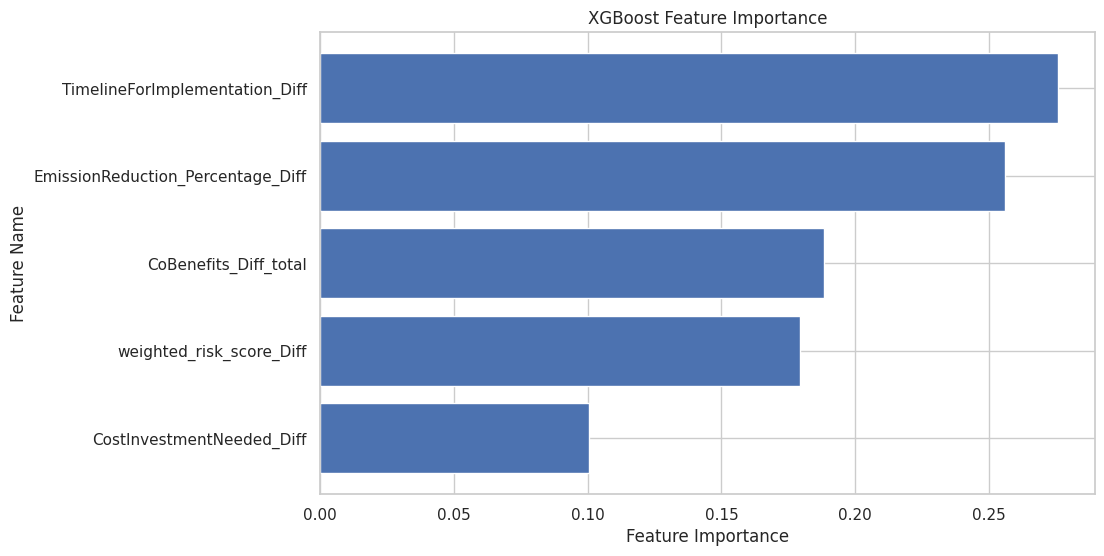

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = xgb_clf.feature_importances_

# Convert to DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': df_X.columns,  # Replace with actual feature names
    'Importance': feature_importance
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Flip for better visualization
plt.show()

##### Checking train vs. test accuracy

A big difference between those two indicates overfitting.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


xgb_clf_various_folds = xgb.XGBClassifier(
        objective="binary:logistic",
        max_depth=9,
        learning_rate=0.158,
        n_estimators=800,
        subsample=0.6,
        colsample_bytree=0.7,
        reg_lambda=0.75,
        reg_alpha=0.0,
        scale_pos_weight=1,
        eval_metric='logloss',
        random_state=42,
        monotone_constraints=monotone_constraints_str
    )

kf1 = KFold(n_splits=5, shuffle=True, random_state=0)
kf2 = KFold(n_splits=5, shuffle=True, random_state=42)

folds = [kf1, kf2]

i = 1

for fold in folds:



    train_scores = []
    val_scores = []

    for train_index, val_index in fold.split(df_X):
        X_train, X_val = df_X.iloc[train_index], df_X.iloc[val_index]
        y_train, y_val = df_y.iloc[train_index], df_y.iloc[val_index]

        xgb_clf_various_folds.fit(X_train, y_train)

        # Get accuracy on training and validation set
        train_pred = xgb_clf_various_folds.predict(X_train)
        val_pred = xgb_clf_various_folds.predict(X_val)

        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)

        train_scores.append(train_acc)
        val_scores.append(val_acc)

    print(f"Average Training Accuracy for fold {i}: {np.mean(train_scores):.4f}")
    print(f"Average Validation Accuracy for fold {i}: {np.mean(val_scores):.4f}")

    i+=1


Average Training Accuracy for fold 1: 0.6828
Average Validation Accuracy for fold 1: 0.6580
Average Training Accuracy for fold 2: 0.6837
Average Validation Accuracy for fold 2: 0.6608


There is only a small difference which indicates no overfitting.

##### SHAP Analysis

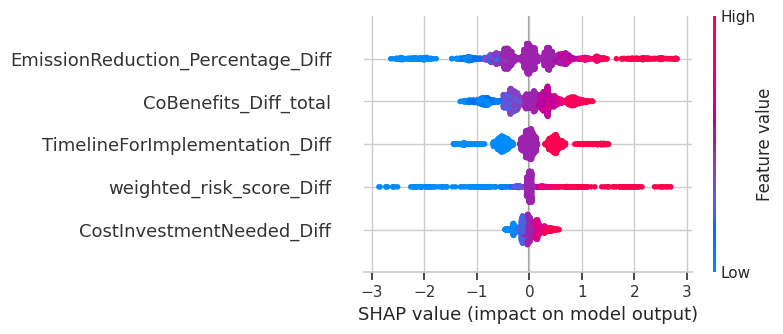

In [ ]:
import shap

# 1. Create a TreeExplainer from your trained model
explainer = shap.TreeExplainer(xgb_clf)

shap_values = explainer(df_X)
shap.summary_plot(shap_values, df_X)

#### Testing on selected city, action pairs

In [ ]:
def pipeline_modified(df: pd.DataFrame) -> pd.DataFrame:
    # df_copy = df.copy()

    # Enriching
    # df_enriched = enrich_df_with_city_and_action_data(df_copy, path_city_data=path_city_data, path_action_data=path_action_data)
    # if remove_adaptation_actions_flag:
    #     df_enriched = remove_adaptation_actions(df_enriched)
    # if remove_mitigation_actions_flag:
    #     df_enriched = remove_mitigation_actions(df_enriched)

    # df_enriched = df_enriched.drop(columns=["SessionID", "note", "city_locode", "city_name", "city_region", "city_regionName", "city_area", "city_socioEconomicFactors", "city_accessToPublicServices", "city_totalEmissions", "city_scope1Emissions", "city_scope2Emissions", "city_scope3Emissions", "actionA_ActionID", "actionA_ActionName", "actionA_Sector", "actionA_Subsector", "actionA_PrimaryPurpose", "actionA_Description", "actionA_EquityAndInclusionConsiderations", "actionA_Dependencies", "actionA_KeyPerformanceIndicators", "actionA_PowersAndMandates", "actionB_ActionID", "actionB_ActionName", "actionB_Sector", "actionB_Subsector", "actionB_PrimaryPurpose", "actionB_Description", "actionB_EquityAndInclusionConsiderations", "actionB_Dependencies", "actionB_KeyPerformanceIndicators", "actionB_PowersAndMandates"])
    df_transformed = df.copy()

    # Transforming
    # df_transformed = convert_preferred_action_to_binary_labels(df_enriched)
    df_transformed = prepare_emission_reduction_data_single_diff(df_transformed)
    df_transformed = prepare_action_type_data(df_transformed)
    df_transformed = prepare_cost_investment_needed_data(df_transformed)
    df_transformed = prepare_timeline_data(df_transformed)
    df_transformed = prepare_adaptation_effectiveness_data(df_transformed)
    # df_transformed = process_ccra_hazards_adaptation_effectiveness(df_transformed)
    df_transformed = process_ccra_hazards_adaptation_effectiveness_per_hazard(df_transformed)
    # df_transformed = prepare_co_benefits_data(df_transformed)
    df_transformed = prepare_co_benefits_data_single_diff(df_transformed)
    df_transformed = prepare_biome_data(df_transformed)
    # df_transformed = prepare_numerical_data(df_transformed,
    #  ['city_populationSize',
    #   'city_populationDensity',
    #   'city_elevation',
    #   'EmissionReduction_Diff_stationary_energy',
    #   'EmissionReduction_Diff_transportation',
    #   'EmissionReduction_Diff_waste',
    #   'EmissionReduction_Diff_ippu',
    #   'EmissionReduction_Diff_afolu',
    #   'CostInvestmentNeeded_Diff',
    #   'TimelineForImplementation_Diff',
    #   'weighted_risk_score_diff',
    #   'CoBenefits_Diff_air_quality',
    #   'CoBenefits_Diff_water_quality',
    #   'CoBenefits_Diff_habitat',
    #   'CoBenefits_Diff_cost_of_living',
    #   'CoBenefits_Diff_housing',
    #   'CoBenefits_Diff_mobility',
    #   'CoBenefits_Diff_stakeholder_engagement'])

    # Final feature selection
    X = [
        # 'city_populationSize', 'city_populationDensity', 'city_elevation',
        # 'EmissionReduction_Diff_total',
        'EmissionReduction_Percentage_Diff',
        # 'EmissionReduction_Diff_stationary_energy', 'EmissionReduction_Diff_transportation',
        # 'EmissionReduction_Diff_waste', 'EmissionReduction_Diff_ippu', 'EmissionReduction_Diff_afolu',
        # 'actionA_mitigation', 'actionA_adaptation', 'actionB_mitigation', 'actionB_adaptation',
        # 'ActionType',
        'CostInvestmentNeeded_Diff', 'TimelineForImplementation_Diff',
        'weighted_risk_score_Diff',
        # 'CoBenefits_Diff_air_quality', 'CoBenefits_Diff_water_quality', 'CoBenefits_Diff_habitat',
        # 'CoBenefits_Diff_cost_of_living', 'CoBenefits_Diff_housing', 'CoBenefits_Diff_mobility',
        # 'CoBenefits_Diff_stakeholder_engagement',
        'CoBenefits_Diff_total'
        # 'biome_temperate_forest', 'biome_desert',
        # 'biome_grassland_savanna', 'biome_tundra', 'biome_wetlands', 'biome_mountains',
        # 'biome_boreal_forest_taiga', 'biome_coastal_marine'
    ]


    # X, y = select_features(mitigation_features=mitigation_features, adaptation_features=adaptation_features, mitigation_adaptation_features=mitigation_adaptation_features)

    df_final = df_transformed[X].copy()

    # print(df_final.isna().sum())  # Counts missing values per column

    # Dropping empty rows
    df_final.dropna(inplace=True)

    # Remove label from df
    # df_X = df_final.drop(columns=['y'])
    # df_y = df_final['y']

    # return df_X, df_y
    return df_final

In [ ]:
# City BRCCI
dict_brcci = {
    "locode": "BRCCI",
    "name": "Camaçari",
    "region": "BR-BA",
    "regionName": "Bahia",
    "populationSize": 300372,
    "populationDensity": 382.43,
    "area": 758.73,
    "elevation": 36,
    "biome": "tropical_rainforest",
    "socioEconomicFactors": {"lowIncome": "very_high"},
    "accessToPublicServices": {
        "inadequateWaterAccess": "very_low",
        "inadequateSanitation": "low",
    },
    "totalEmissions": 3390145659.0,
    "stationaryEnergyEmissions": 176766789.0,
    "transportationEmissions": 295693000.0,
    "wasteEmissions": 1124796988.0,
    "industrialProcessEmissions": 1720470000,
    "landUseEmissions": 72418882.0,
    "scope1Emissions": 3214434494.0,
    "scope2Emissions": 171982146.0,
    "scope3Emissions": 3729019.0,
    "ccra": [
        {
            "keyimpact": "public health",
            "hazard": "diseases",
            "normalised_risk_score": 0.99,
        },
        {
            "keyimpact": "water resources",
            "hazard": "droughts",
            "normalised_risk_score": 0.35978153341031,
        },
        {
            "keyimpact": "food security",
            "hazard": "droughts",
            "normalised_risk_score": 0.644653441267234,
        },
        {
            "keyimpact": "energy security",
            "hazard": "droughts",
            "normalised_risk_score": 0.989051161784754,
        },
        {
            "keyimpact": "biodiversity",
            "hazard": "droughts",
            "normalised_risk_score": 0.0625445839710777,
        },
        {
            "keyimpact": "public health",
            "hazard": "heatwaves",
            "normalised_risk_score": 0.99,
        },
        {
            "keyimpact": "infrastructure",
            "hazard": "heatwaves",
            "normalised_risk_score": 0.493855416086134,
        },
        {
            "keyimpact": "biodiversity",
            "hazard": "heatwaves",
            "normalised_risk_score": 0.223576599435519,
        },
        {
            "keyimpact": "energy security",
            "hazard": "heatwaves",
            "normalised_risk_score": 0.99,
        },
        {
            "keyimpact": "infrastructure",
            "hazard": "landslides",
            "normalised_risk_score": 0.797726778999126,
        },
        {
            "keyimpact": "food security",
            "hazard": "floods",
            "normalised_risk_score": 0.99,
        },
        {
            "keyimpact": "infrastructure",
            "hazard": "sea-level-rise",
            "normalised_risk_score": 0.00,
        },
    ],
}

dict_brcxl = {
    "locode": "BRCXL",
    "name": "Caxias do Sul",
    "region": "BR-RS",
    "regionName": "Rio Grande do Sul",
    "populationSize": 463501,
    "populationDensity": 280.52,
    "area": 1643.0,
    "elevation": 817,
    "biome": "tropical_rainforest",
    "socioEconomicFactors": {
        "lowIncome": "very_high"
    },
    "accessToPublicServices": {
        "inadequateWaterAccess": "very_low",
        "inadequateSanitation": "very_low"
    },
    "totalEmissions": 4527548810.0,
    "stationaryEnergyEmissions": 151964298.0,
    "transportationEmissions": 554225715.0,
    "wasteEmissions": 3564978296.0,
    "industrialProcessEmissions": 1037560,
    "landUseEmissions": 255342941.0,
    "scope1Emissions": 4276317120.0,
    "scope2Emissions": 180996493.0,
    "scope3Emissions": 70235197.0,
    "ccra": [
        {
            "keyimpact": "water resources",
            "hazard": "droughts",
            "normalised_risk_score": 0.510528369643004
        },
        {
            "keyimpact": "food security",
            "hazard": "droughts",
            "normalised_risk_score": 0.458632609619644
        },
        {
            "keyimpact": "energy security",
            "hazard": "droughts",
            "normalised_risk_score": 0.0724515428343302
        },
        {
            "keyimpact": "biodiversity",
            "hazard": "droughts",
            "normalised_risk_score": 0.0270386645155329
        },
        {
            "keyimpact": "public health",
            "hazard": "heatwaves",
            "normalised_risk_score": 0.299037399579896
        },
        {
            "keyimpact": "infrastructure",
            "hazard": "heatwaves",
            "normalised_risk_score": 0.395560152611115
        },
        {
            "keyimpact": "biodiversity",
            "hazard": "heatwaves",
            "normalised_risk_score": 0.012949618678994
        },
        {
            "keyimpact": "energy security",
            "hazard": "heatwaves",
            "normalised_risk_score": 0.0398131590796516
        },
        {
            "keyimpact": "public health",
            "hazard": "diseases",
            "normalised_risk_score": 0.599359431398059
        },
        {
            "keyimpact": "infrastructure",
            "hazard": "landslides",
            "normalised_risk_score": 0.99
        },
        {
            "keyimpact": "public health",
            "hazard": "landslides",
            "normalised_risk_score": 0.99
        },
        {
            "keyimpact": "infrastructure",
            "hazard": "floods",
            "normalised_risk_score": 0.99
        },
        {
            "keyimpact": "food security",
            "hazard": "floods",
            "normalised_risk_score": 0.926525011340596
        },
        {
            "keyimpact": "public health",
            "hazard": "floods",
            "normalised_risk_score": 0.99
        },
        {
            "keyimpact": "infrastructure",
            "hazard": "sea-level-rise",
            "normalised_risk_score": None
        }
    ]
}

dict_brmge = {
    "locode": "BRMGE",
    "name": "Maranguape",
    "region": "BR-CE",
    "regionName": "Ceará",
    "populationSize": 105093,
    "populationDensity": 180.11,
    "area": 583,
    "elevation": 68,
    "biome": "desert",
    "socioEconomicFactors": {
        "lowIncome": "very_high"
    },
    "accessToPublicServices": {
        "inadequateWaterAccess": "low",
        "inadequateSanitation": "moderate"
    },
    "totalEmissions": 129440000,
    "stationaryEnergyEmissions": 14440000,
    "transportationEmissions": 34790000,
    "wasteEmissions": 20200000,
    "industrialProcessEmissions": 513480,
    "landUseEmissions": 59500000,
    "scope1Emissions": 124199470,
    "scope2Emissions": 5262860,
    "scope3Emissions": 0.0,
    "ccra": [
        {
            "keyimpact": "water resources",
            "hazard": "droughts",
            "normalised_risk_score": 0.99
        },
        {
            "keyimpact": "food security",
            "hazard": "droughts",
            "normalised_risk_score": 0.99
        },
        {
            "keyimpact": "energy security",
            "hazard": "droughts",
            "normalised_risk_score": 0.99
        },
        {
            "keyimpact": "biodiversity",
            "hazard": "droughts",
            "normalised_risk_score": 0.356962946875303
        },
        {
            "keyimpact": "public health",
            "hazard": "heatwaves",
            "normalised_risk_score": 0.99
        },
        {
            "keyimpact": "infrastructure",
            "hazard": "heatwaves",
            "normalised_risk_score": 0.331733453994424
        },
        {
            "keyimpact": "biodiversity",
            "hazard": "heatwaves",
            "normalised_risk_score": 0.18769616961873
        },
        {
            "keyimpact": "energy security",
            "hazard": "heatwaves",
            "normalised_risk_score": 0.707596429811259
        },
        {
            "keyimpact": "public health",
            "hazard": "diseases",
            "normalised_risk_score": 0.99
        },
        {
            "keyimpact": "infrastructure",
            "hazard": "landslides",
            "normalised_risk_score": 0.378405049782624
        },
        {
            "keyimpact": "public health",
            "hazard": "landslides",
            "normalised_risk_score": 0.671199898083366
        },
        {
            "keyimpact": "infrastructure",
            "hazard": "floods",
            "normalised_risk_score": 0.332432449268308
        },
        {
            "keyimpact": "food security",
            "hazard": "floods",
            "normalised_risk_score": 0.655675697290852
        },
        {
            "keyimpact": "public health",
            "hazard": "floods",
            "normalised_risk_score": 0.301694165152786
        },
        {
            "keyimpact": "infrastructure",
            "hazard": "sea-level-rise",
            "normalised_risk_score": None
        }
    ]
}

dict_icare_0118 = {
    "ActionID": "icare_0118",
    "ActionName": "Promote the use of bicycles as a regular mode of transport through the expansion of infrastructure and strategies for awareness and communication.",
    "ActionType": ["mitigation"],
    "Hazard": None,
    "Sector": ["transportation"],
    "Subsector": ["on-road"],
    "PrimaryPurpose": ["ghg_reduction"],
    "Description": "Encourage the adoption of bicycles as a regular mode of transport by expanding cycling infrastructure, such as dedicated bike lanes, parking facilities, and repair stations. Additionally, implement awareness campaigns and communication strategies to highlight the environmental, health, and economic benefits of cycling, aiming to increase public participation and make cycling a viable and sustainable transport option for daily commuting.",
    "CoBenefits": {
        "air_quality": 2,
        "water_quality": 0,
        "habitat": 0,
        "cost_of_living": 1,
        "housing": 1,
        "mobility": 2,
        "stakeholder_engagement": 1
    },
    "EquityAndInclusionConsiderations": None,
    "GHGReductionPotential": {
        "stationary_energy": None,
        "transportation": "60-79",
        "waste": None,
        "ippu": None,
        "afolu": None
    },
    "AdaptationEffectiveness": None,
    "CostInvestmentNeeded": "medium",
    "TimelineForImplementation": "5-10 years",
    "Dependencies": [
        "Expand cycling infrastructure, including dedicated bike lanes, parking facilities, and repair stations.",
        "Implement awareness campaigns to highlight the environmental, health, and economic benefits of cycling.",
        "Promote public participation through communication strategies, making cycling a viable and sustainable option for daily commuting."
    ],
    "KeyPerformanceIndicators": [
        "Length of new bike lanes added to the urban network (km).",
        "Annual increase in the number of bicycle users in urban areas.",
        "Estimated reduction in CO\u2082 equivalent emissions from the shift to cycling."
    ],
    "PowersAndMandates": ["local"]
}


dict_icare_0075 = {
    "ActionID": "icare_0075",
    "ActionName": "Set carbon emissions reduction targets for industrial sectors",
    "ActionType": ["mitigation"],
    "Hazard": None,
    "Sector": ["ippu"],
    "Subsector": ["industrial_processes"],
    "PrimaryPurpose": ["ghg_reduction"],
    "Description": "Establish clear and achievable carbon emissions reduction goals for industries and require periodic reporting to ensure progress.",
    "CoBenefits": {
        "air_quality": 2,
        "water_quality": 1,
        "habitat": 1,
        "cost_of_living": 0,
        "housing": 0,
        "mobility": 0,
        "stakeholder_engagement": 2,
    },
    "EquityAndInclusionConsiderations": None,
    "GHGReductionPotential": {
        "stationary_energy": None,
        "transportation": None,
        "waste": None,
        "ippu": "80-100",
        "afolu": None,
    },
    "AdaptationEffectiveness": None,
    "CostInvestmentNeeded": "low",
    "TimelineForImplementation": "5-10 years",
    "Dependencies": [
        "Development of a standardized carbon emissions measurement and reporting system.",
        "Creation of regulatory frameworks to enforce emissions reduction goals.",
        "Capacity-building for industries to monitor and report emissions effectively.",
    ],
    "KeyPerformanceIndicators": [
        "Percentage of industries with established carbon reduction targets (%).",
        "Reduction in total sectoral GHG emissions compared to baseline (tons of CO\u2082e).",
        "Increase in adoption of renewable energy sources by industries (%).",
    ],
    "PowersAndMandates": ["local"],
}

# Action_A 2
dict_c40_0009 = {
    "ActionID": "c40_0009",
    "ActionName": "New Building Standards",
    "ActionType": ["mitigation"],
    "Hazard": None,
    "Sector": ["stationary_energy"],
    "Subsector": ["all"],
    "PrimaryPurpose": ["ghg_reduction"],
    "Description": '"New Building Standards" set guidelines for environmentally responsible construction, ensuring that new structures adhere to energy-efficient practices, thereby reducing carbon emissions and promoting sustainable urban development.',
    "CoBenefits": {
        "air_quality": 1,
        "water_quality": 0,
        "habitat": 0,
        "cost_of_living": 0,
        "housing": -1,
        "mobility": 0,
        "stakeholder_engagement": 0,
    },
    "EquityAndInclusionConsiderations": 'The "New Building Standards" promote equity and inclusion by ensuring that all new constructions, including those in vulnerable or underserved communities, adhere to energy-efficient practices. This helps to reduce energy costs for residents, making housing more affordable and accessible. Additionally, by prioritizing sustainable urban development, these standards can lead to improved living conditions and health outcomes in these communities, which often face disproportionate environmental burdens. Furthermore, the implementation of these standards can create job opportunities in green construction, benefiting local workers and fostering economic empowerment in underserved areas. Overall, the action considers the needs of vulnerable populations by promoting sustainable practices that enhance their quality of life and economic stability.',
    "GHGReductionPotential": {
        "stationary_energy": "0-19",
        "transportation": None,
        "waste": None,
        "ippu": None,
        "afolu": None,
    },
    "AdaptationEffectiveness": None,
    "CostInvestmentNeeded": "low",
    "TimelineForImplementation": "<5 years",
    "Dependencies": [
        "Regulatory framework to enforce building standards",
        "Availability of sustainable construction materials",
        "Training and education for builders and architects on energy-efficient practices",
        "Monitoring and evaluation systems to assess compliance with standards",
        "Public awareness and support for sustainable building practices",
    ],
    "KeyPerformanceIndicators": [
        "Reduction in carbon emissions from new buildings",
        "Percentage of new buildings meeting energy efficiency standards",
        "Increase in the use of sustainable materials in construction",
        "Number of buildings certified under green building standards",
        "Energy consumption reduction in new constructions",
        "Percentage of urban development projects incorporating green spaces",
    ],
    "PowersAndMandates": None,
}

# Action_A 2
dict_icare_0073 = {
    "ActionID": "icare_0073",
    "ActionName": "Support the transition to low-emission industrial refrigeration",
    "ActionType": ["mitigation"],
    "Hazard": None,
    "Sector": ["ippu"],
    "Subsector": ["industrial_processes"],
    "PrimaryPurpose": ["ghg_reduction"],
    "Description": "Replace high-GWP refrigerants with low-emission, energy-efficient alternatives in industrial refrigeration systems.",
    "CoBenefits": {
        "air_quality": 2,
        "water_quality": 1,
        "habitat": 1,
        "cost_of_living": 1,
        "housing": 0,
        "mobility": 0,
        "stakeholder_engagement": 1
    },
    "EquityAndInclusionConsiderations": None,
    "GHGReductionPotential": {
        "stationary_energy": None,
        "transportation": None,
        "waste": None,
        "ippu": "60-79",
        "afolu": None
    },
    "AdaptationEffectiveness": None,
    "CostInvestmentNeeded": "medium",
    "TimelineForImplementation": "5-10 years",
    "Dependencies": [
        "Availability of lowGWP refrigerants and compatible equipment.",
        "Regulatory support for phasing out highGWP refrigerants.",
        "Training programs for industry professionals on new refrigerant systems."
    ],
    "KeyPerformanceIndicators": [
        "Number of industrial refrigeration systems transitioned to low-emission alternatives.",
        "Reduction in greenhouse gas emissions from refrigeration systems (tons of CO\u2082 equivalent/year).",
        "Percentage of local businesses receiving support for transitioning (%)."
    ],
    "PowersAndMandates": ["local"]
}

# Action_B
dict_c40_0023 = {
    "ActionID": "c40_0023",
    "ActionName": "Bus Emissions",
    "ActionType": ["mitigation"],
    "Hazard": None,
    "Sector": ["transportation"],
    "Subsector": ["on-road"],
    "PrimaryPurpose": ["ghg_reduction"],
    "Description": '"Bus Emissions" mitigation focuses on reducing the environmental impact of bus fleets. Implementing cleaner technologies and fuels helps minimize emissions, contributing to improved air quality and sustainable urban transportation.',
    "CoBenefits": {
        "air_quality": 1,
        "water_quality": 0,
        "habitat": 0,
        "cost_of_living": 0,
        "housing": 0,
        "mobility": 0,
        "stakeholder_engagement": 0,
    },
    "EquityAndInclusionConsiderations": 'The "Bus Emissions" mitigation action promotes equity and inclusion by targeting improvements in air quality, which directly benefits vulnerable and underserved communities that are often disproportionately affected by pollution. By implementing cleaner technologies and fuels in bus fleets, the action reduces harmful emissions in areas where low-income populations and marginalized groups reside, thereby addressing environmental justice concerns. Additionally, enhancing urban transportation through cleaner buses ensures that all community members, including those who rely on public transit, have access to healthier and more sustainable transportation options. This approach fosters inclusivity by prioritizing the needs of those who may have limited mobility or financial resources, ensuring that the benefits of cleaner air and improved transit are equitably distributed.',
    "GHGReductionPotential": {
        "stationary_energy": None,
        "transportation": "20-39",
        "waste": None,
        "ippu": None,
        "afolu": None,
    },
    "AdaptationEffectiveness": None,
    "CostInvestmentNeeded": "medium",
    "TimelineForImplementation": "<5 years",
    "Dependencies": [
        "Availability of cleaner technologies and fuels for bus fleets",
        "Investment in infrastructure to support cleaner bus operations",
        "Regulatory support and incentives for adopting low-emission buses",
        "Public awareness and acceptance of cleaner transportation options",
        "Collaboration between government, transit authorities, and manufacturers",
    ],
    "KeyPerformanceIndicators": [
        "Reduction in CO2 emissions (tons)",
        "Percentage of bus fleet using clean technologies",
        "Fuel efficiency of bus fleet (miles per gallon)",
        "Number of buses retrofitted or replaced with cleaner models",
        "Air quality improvement metrics (e.g., PM2.5 levels)",
        "Public transportation ridership rates",
        "Cost savings from fuel efficiency improvements",
        "Percentage reduction in nitrogen oxides (NOx) emissions",
    ],
    "PowersAndMandates": None,
}

dict_c40_0034 = {
    "ActionID": "c40_0034",
    "ActionName": "Material Bans",
    "ActionType": ["mitigation"],
    "Hazard": None,
    "Sector": ["waste"],
    "Subsector": ["disposal_of_solid_waste_generated_in_the_city"],
    "PrimaryPurpose": ["ghg_reduction"],
    "Description": "\"Material Bans\" involve imposing restrictions on single-use or non-recyclable materials to reduce environmental impact. By prohibiting certain materials, cities aim to promote the use of sustainable alternatives, contributing to waste reduction and overall environmental conservation.",
    "CoBenefits": {
      "air_quality": 0,
      "water_quality": 1,
      "habitat": 0,
      "cost_of_living": 0,
      "housing": 0,
      "mobility": 0,
      "stakeholder_engagement": 0
    },
    "EquityAndInclusionConsiderations": "The \"Material Bans\" climate action promotes equity and inclusion by addressing the disproportionate impact of waste and pollution on vulnerable and underserved communities. By reducing single-use and non-recyclable materials, the action helps to improve environmental health in areas that are often more affected by waste management issues. \n \n Additionally, the promotion of sustainable alternatives can create economic opportunities for local businesses, particularly those in underserved areas, by encouraging the development and distribution of eco-friendly products. This can lead to job creation and support for local economies.\n \n Furthermore, the implementation of material bans often involves community engagement and education, ensuring that the voices of marginalized groups are heard and considered in the decision-making process. This participatory approach fosters a sense of ownership and empowerment among community members, enhancing social equity. \n \n Overall, the action not only aims to reduce environmental impact but also actively considers the needs and contributions of vulnerable populations, promoting a more inclusive and equitable transition to sustainability.",
    "GHGReductionPotential": {
      "stationary_energy": None,
      "transportation": None,
      "waste": "0-19",
      "ippu": None,
      "afolu": None
    },
    "AdaptationEffectiveness": None,
    "CostInvestmentNeeded": "low",
    "TimelineForImplementation": "<5 years",
    "Dependencies": [
      "Public awareness and support for environmental issues",
      "Availability of sustainable alternatives to banned materials",
      "Effective enforcement mechanisms to ensure compliance with bans",
      "Collaboration with businesses to transition to eco-friendly practices",
      "Education and outreach programs to inform the community about the changes"
    ],
    "KeyPerformanceIndicators": [
      "Reduction in single-use material consumption",
      "Increase in recycling rates",
      "Amount of waste diverted from landfills",
      "Number of sustainable alternatives adopted",
      "Public awareness and engagement levels",
      "Compliance rate among businesses",
      "Reduction in litter in public spaces",
      "Carbon footprint reduction associated with material bans"
    ],
    "PowersAndMandates": None
  }

dict_c40_0036 = {
    "ActionID": "c40_0036",
    "ActionName": "Landfill Management",
    "ActionType": ["mitigation"],
    "Hazard": None,
    "Sector": ["waste"],
    "Subsector": ["all"],
    "PrimaryPurpose": ["ghg_reduction"],
    "Description": "\"Landfill Management\" strategies focus on responsible and sustainable landfill practices to minimize environmental degradation. By adopting effective management techniques, cities aim to reduce the ecological footprint associated with landfill sites and encourage waste reduction.",
    "CoBenefits": {
      "air_quality": 1,
      "water_quality": 1,
      "habitat": 0,
      "cost_of_living": 0,
      "housing": 0,
      "mobility": 0,
      "stakeholder_engagement": 0
    },
    "EquityAndInclusionConsiderations": "The \"Landfill Management\" strategies promote equity and inclusion by addressing the environmental impacts of landfill sites, which often disproportionately affect vulnerable and underserved communities. These communities frequently reside near landfills and are more susceptible to health risks associated with pollution and environmental degradation. By implementing responsible and sustainable landfill practices, the action aims to reduce these negative impacts, thereby improving the quality of life for residents in these areas.\n \n Additionally, effective waste reduction techniques can create opportunities for community engagement and participation, allowing underserved populations to have a voice in local environmental decisions. This inclusion fosters a sense of ownership and empowerment among community members, ensuring that their needs and concerns are considered in the management of landfill sites. Overall, the action acknowledges and seeks to mitigate the inequities faced by marginalized communities in relation to waste management and environmental health.",
    "GHGReductionPotential": {
      "stationary_energy": None,
      "transportation": None,
      "waste": "60-79",
      "ippu": None,
      "afolu": None
    },
    "AdaptationEffectiveness": None,
    "CostInvestmentNeeded": "medium",
    "TimelineForImplementation": "<5 years",
    "Dependencies": [
      "Effective waste segregation practices to ensure proper disposal and recycling",
      "Investment in technology for waste treatment and landfill monitoring",
      "Community engagement and education on waste reduction and recycling",
      "Regulatory frameworks and policies supporting sustainable landfill practices",
      "Collaboration with local governments and organizations for resource sharing and best practices"
    ],
    "KeyPerformanceIndicators": [
      "Reduction in landfill waste volume",
      "Percentage of waste diverted from landfills",
      "Rate of landfill gas capture",
      "Soil and water quality around landfill sites",
      "Frequency of landfill inspections",
      "Public awareness and engagement levels",
      "Cost savings from improved landfill management practices",
      "Compliance with environmental regulations"
    ],
    "PowersAndMandates": None
  }

dict_c40_0042 = {
    "ActionID": "c40_0042",
    "ActionName": "Biodiversity Expansion",
    "ActionType": ["mitigation"],
    "Hazard": None,
    "Sector": ["afolu"],
    "Subsector": None,
    "PrimaryPurpose": ["ghg_reduction"],
    "Description": "\"Biodiversity Expansion\" initiatives aim to preserve and expand green spaces, promoting biodiversity within urban areas. By preserving natural habitats, cities enhance ecosystem services and create resilient environments that support diverse flora and fauna.",
    "CoBenefits": {
        "air_quality": 1,
        "water_quality": 1,
        "habitat": 1,
        "cost_of_living": 0,
        "housing": 0,
        "mobility": 0,
        "stakeholder_engagement": 0
    },
    "EquityAndInclusionConsiderations": "The \"Biodiversity Expansion\" initiatives promote equity and inclusion by ensuring that underserved communities have access to preserved green spaces, which are often lacking in urban areas. By focusing on enhancing biodiversity in these neighborhoods, the action addresses environmental justice by improving the quality of life for vulnerable populations who may face higher exposure to pollution and limited access to nature. Additionally, the creation of resilient environments supports diverse flora and fauna, which can enhance local ecosystems that these communities rely on for recreational, cultural, and economic benefits. Overall, the initiative fosters a sense of community ownership and involvement in the preservation of natural habitats, ensuring that the voices of marginalized groups are included in urban planning and environmental stewardship.",
    "GHGReductionPotential": {
        "stationary_energy": None,
        "transportation": None,
        "waste": None,
        "ippu": None,
        "afolu": "40-59"
    },
    "AdaptationEffectiveness": None,
    "CostInvestmentNeeded": "low",
    "TimelineForImplementation": "5-10 years",
    "Dependencies": [
        "Availability of funding for green space projects",
        "Community engagement and support for biodiversity initiatives",
        "Collaboration with local governments and environmental organizations",
        "Access to scientific research on local ecosystems",
        "Regulatory frameworks that support land conservation and urban planning"
    ],
    "KeyPerformanceIndicators": [
        "Increase in green space area (hectares)",
        "Number of native species introduced",
        "Biodiversity index improvement",
        "Percentage of urban areas with accessible green spaces",
        "Community engagement in biodiversity programs",
        "Reduction in urban heat island effect",
        "Increase in pollinator populations",
        "Improvement in air quality metrics",
        "Number of partnerships with local conservation organizations",
        "Public awareness and education outreach metrics"
    ],
    "PowersAndMandates": None
    }

dict_icare_0145 = {
"ActionID": "icare_0145",
"ActionName": "Strengthen the healthcare network to attend to climate victims",
"ActionType": [
    "adaptation"
],
"Hazard": [
    "heatwaves",
    "diseases",
    "landslides",
    "floods",
    "storms",
    "droughts"
],
"Sector": None,
"Subsector": None,
"PrimaryPurpose": [
    "climate_resilience"
],
"Description": "Improve the infrastructure of healthcare units to assist people who require medical care due to impacts associated with climate risks (climate victims), such as those affected by heat waves or floods, especially in more vulnerable areas. Develop action plans to prepare the healthcare network for extreme climate-related situations.",
"CoBenefits": {
    "air_quality": 0,
    "water_quality": 0,
    "habitat": 0,
    "cost_of_living": 0,
    "housing": 0,
    "mobility": 0,
    "stakeholder_engagement": 2
},
"EquityAndInclusionConsiderations": None,
"GHGReductionPotential": None,
"AdaptationEffectiveness": "high",
"CostInvestmentNeeded": "high",
"TimelineForImplementation": ">10 years",
"Dependencies": [
    "Investment in the renovation and expansion of healthcare facilities, ensuring they are equipped to handle climate-related health impacts, particularly in vulnerable areas.",
    "Development of action plans and training programs for healthcare professionals to respond to extreme climate events like heatwaves and floods.",
    "Collaboration with local authorities, emergency response teams, and climate experts to create a comprehensive framework for preparing the healthcare network for climate risks."
],
"KeyPerformanceIndicators": [
    "Number of healthcare facilities upgraded for climate-related emergencies.",
    "Increase in healthcare staff trained in climate emergency response (%).",
    "Number of climate-related injuries treated successfully.",
    "."
],
"PowersAndMandates": [
    "national"
],
"AdaptationEffectivenessPerHazard": {
    "heatwaves": "high",
    "diseases": "medium",
    "landslides": "medium",
    "floods": "high",
    "storms": "high",
    "droughts": "medium"
}
}

dict_icare_0140 = {
    "ActionID": "icare_0140",
    "ActionName": "Landslide Risk Assessment and Management",
    "ActionType": [
      "adaptation"
    ],
    "Hazard": [
      "landslides"
    ],
    "Sector": None,
    "Subsector": None,
    "PrimaryPurpose": [
      "climate_resilience"
    ],
    "Description": "This action involves assessing and managing landslide risks by collecting data, mapping hazard areas, and conducting evacuation simulations. It aims to reduce the risks associated with landslides in areas prone to these events.",
    "CoBenefits": {
      "air_quality": 1,
      "water_quality": 2,
      "habitat": 2,
      "cost_of_living": 1,
      "housing": 1,
      "mobility": 1,
      "stakeholder_engagement": 2
    },
    "EquityAndInclusionConsiderations": None,
    "GHGReductionPotential": None,
    "AdaptationEffectiveness": "high",
    "CostInvestmentNeeded": "low",
    "TimelineForImplementation": "<5 years",
    "Dependencies": [
      "Comprehensive planning and policy framework",
      "Stakeholder participation",
      "Capacity building and institutional support"
    ],
    "KeyPerformanceIndicators": [
      "Coastal erosion rates",
      "Water quality",
      "Habitat health"
    ],
    "PowersAndMandates": [
      "local"
    ],
    "AdaptationEffectivenessPerHazard": {
      "landslides": "high"
    }
  }


In [ ]:
def build_df(city, action_A, action_B):
    """
    Create a DataFrame to hold the city data and the actions data.
    """
    data = {}

    # 1. Add action IDs directly (as the ActionA and ActionB columns)
    data["ActionA"] = action_A.get("ActionID")
    data["ActionB"] = action_B.get("ActionID")

    # 2. Add selected city attributes with a "city_" prefix
    city_keys = [
        "populationSize",
        "populationDensity",
        "elevation",
        "biome",
        "stationaryEnergyEmissions",
        "transportationEmissions",
        "wasteEmissions",
        "industrialProcessEmissions",
        "landUseEmissions",
        "ccra",
    ]
    for key in city_keys:
        data[f"city_{key}"] = city.get(key)

    # 3. Add action-specific attributes with the appropriate prefixes
    action_keys = [
        "ActionType",
        "Hazard",
        "CoBenefits",
        "GHGReductionPotential",
        "AdaptationEffectiveness",
        "CostInvestmentNeeded",
        "TimelineForImplementation",
        "AdaptationEffectivenessPerHazard"
    ]
    for key in action_keys:
        data[f"actionA_{key}"] = action_A.get(key)
    for key in action_keys:
        data[f"actionB_{key}"] = action_B.get(key)

    # Create a DataFrame from the dictionary (each key becomes a column)
    df = pd.DataFrame([data])

    return df

In [ ]:
import shap

def create_shap_waterfall(df: pd.DataFrame, model: xgb.XGBClassifier) -> None:
    """
    Create a SHAP waterfall plot for the given dataframe.
    The function will create a SHAP waterfall plot for the given dataframe.

    Args:
        df (pd.DataFrame): The dataframe to create the SHAP waterfall plot for.

    Returns:
        None
    """

    explainer = shap.TreeExplainer(model)

    # 3. Get SHAP values for that single row
    shap_values = explainer(df)

    # 4. Plot a waterfall for the first (and only) row
    shap.plots.waterfall(shap_values[0], max_display=30)

For city BRCCI

- "stationaryEnergyEmissions": 176,766,789.0,
- "transportationEmissions": 295,693,000.0,
- "wasteEmissions": 1,124,796,988.0,
- **"industrialProcessEmissions": 1,720,470,000,**
- "landUseEmissions": 72,418,882.0,

Actions:

- dict_icare_0075 - high ippu
- dict_c40_0023 - medium transportation
- dict_c40_0042 - medium afolu
- dict_0009 - low stationary energy

                                          0
EmissionReduction_Percentage_Diff  39.61235
CostInvestmentNeeded_Diff           1.00000
TimelineForImplementation_Diff      0.00000
weighted_risk_score_Diff            0.00000
CoBenefits_Diff_total              -1.00000
[1]
Acction A


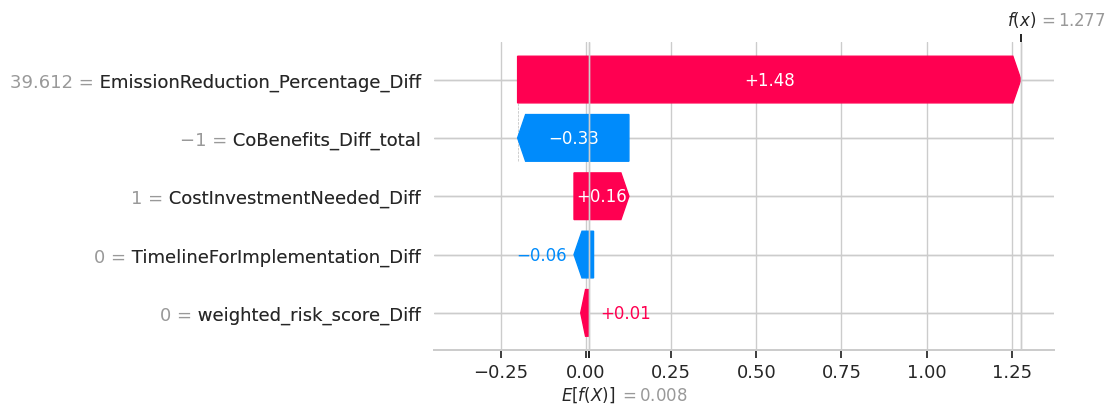

In [ ]:
df_selected_pair = build_df(dict_brcci, dict_icare_0075, dict_icare_0118)

df_X_selected_pair = pipeline_modified(df_selected_pair)
print(df_X_selected_pair.T)

prediction_selected_pair = xgb_clf.predict(df_X_selected_pair)
print(prediction_selected_pair)
if prediction_selected_pair[0] == 1:
    print("Acction A")
else:
    print("Action B")

create_shap_waterfall(df_X_selected_pair, xgb_clf)

                                          0
EmissionReduction_Percentage_Diff -2.077686
CostInvestmentNeeded_Diff          1.000000
TimelineForImplementation_Diff     0.000000
weighted_risk_score_Diff           0.000000
CoBenefits_Diff_total             -1.000000
[0]
Action B


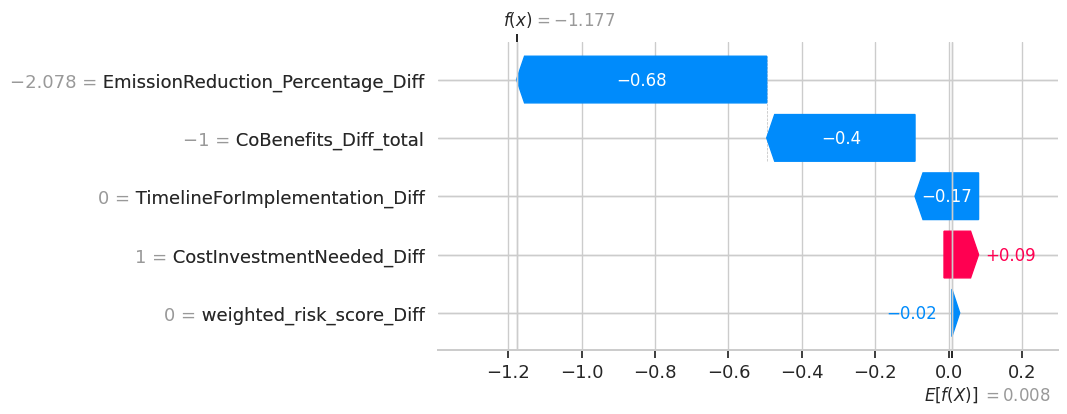

In [ ]:
df_selected_pair = build_df(dict_brcci, dict_c40_0009, dict_c40_0023)
# df_selected_pair = build_df(dict_brcci, dict_icare_0075,dict_c40_0009)
# df_selected_pair = build_df(dict_brcci, dict_icare_0075, dict_c40_0023)
# df_selected_pair = build_df(dict_brcci, dict_c40_0023, dict_c40_0042)

df_X_selected_pair = pipeline_modified(df_selected_pair)

print(df_X_selected_pair.T)

prediction_selected_pair = xgb_clf.predict(df_X_selected_pair)
print(prediction_selected_pair)
if prediction_selected_pair[0] == 1:
    print("Acction A")
else:
    print("Action B")

create_shap_waterfall(df_X_selected_pair, xgb_clf)

For city BRCXL

- "stationaryEnergyEmissions":     151.964.298.0,
- "transportationEmissions":       554.225.715.0,
- **"wasteEmissions":            3.564.978.296.0,**
- "industrialProcessEmissions":      1.037.560,
- "landUseEmissions":                255342941.0,

Actions:
- dict_c40_0034 - low waste
- dict_c40_0036 - high waste
- dict_c40_0023 - high transportation

[1]
Acction A


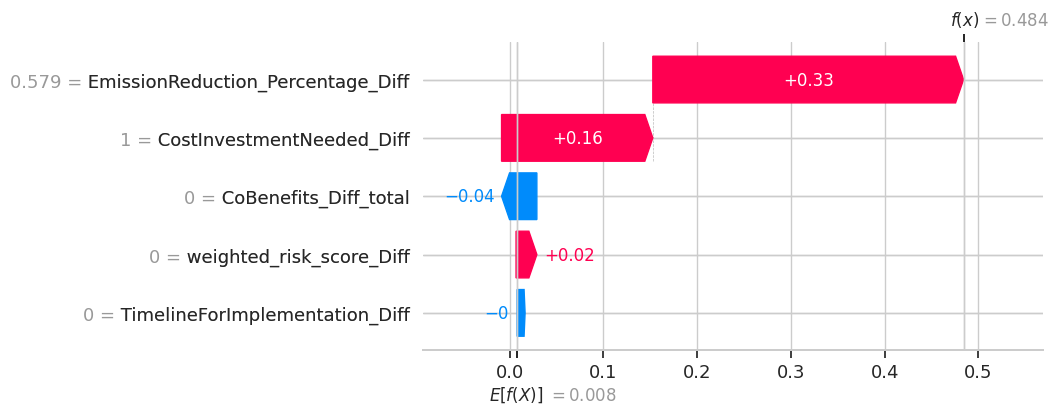

In [ ]:
df_selected_pair = build_df(dict_brcci, dict_c40_0034, dict_c40_0023)

df_X_selected_pair = pipeline_modified(df_selected_pair)
df_X_selected_pair.T

prediction_selected_pair = xgb_clf.predict(df_X_selected_pair)
print(prediction_selected_pair)
if prediction_selected_pair[0] == 1:
    print("Acction A")
else:
    print("Action B")

create_shap_waterfall(df_X_selected_pair, xgb_clf)

BRMGE

- "stationaryEnergyEmissions": 14,440,000,
- "transportationEmissions": 34,790,000,
- "wasteEmissions": 20,200,000,
- "industrialProcessEmissions": 513,480,
- **"landUseEmissions": 59,500,000**,

Actions:

- dict_icare_0075 - high ippu
- dict_c40_0023 - high transportation
- dict_c40_0042 - medium afolu


                                           0
EmissionReduction_Percentage_Diff  22.396159
CostInvestmentNeeded_Diff           0.000000
TimelineForImplementation_Diff      0.000000
weighted_risk_score_Diff            0.000000
CoBenefits_Diff_total              -3.000000
[1]
Acction A


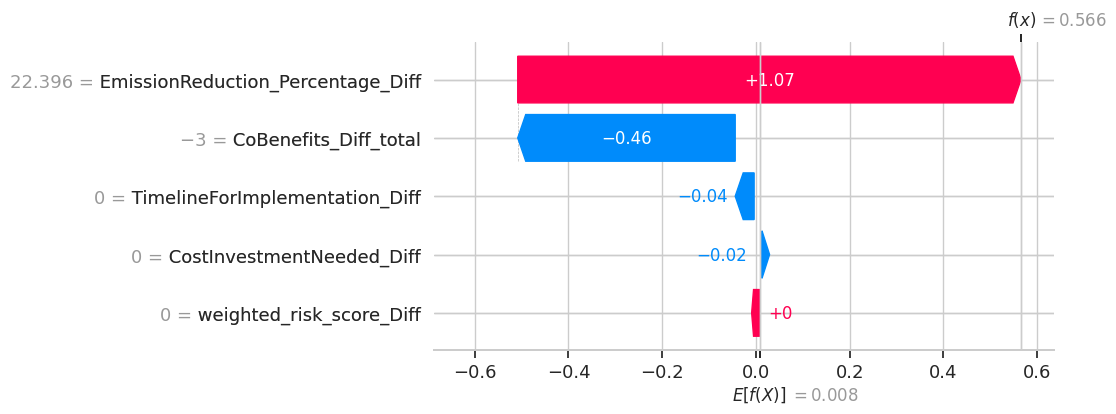

In [ ]:
# df_selected_pair = build_df(dict_brmge, dict_c40_0023, dict_c40_0042)
df_selected_pair = build_df(dict_brmge, dict_c40_0042, dict_icare_0075)

df_X_selected_pair = pipeline_modified(df_selected_pair)
print(df_X_selected_pair.T)

prediction_selected_pair = xgb_clf.predict(df_X_selected_pair)
print(prediction_selected_pair)
if prediction_selected_pair[0] == 1:
    print("Acction A")
else:
    print("Action B")

create_shap_waterfall(df_X_selected_pair, xgb_clf)

                                           0
EmissionReduction_Percentage_Diff -14.824578
CostInvestmentNeeded_Diff          -1.000000
TimelineForImplementation_Diff      1.000000
weighted_risk_score_Diff            0.000000
CoBenefits_Diff_total              -2.000000
[0]
Action B


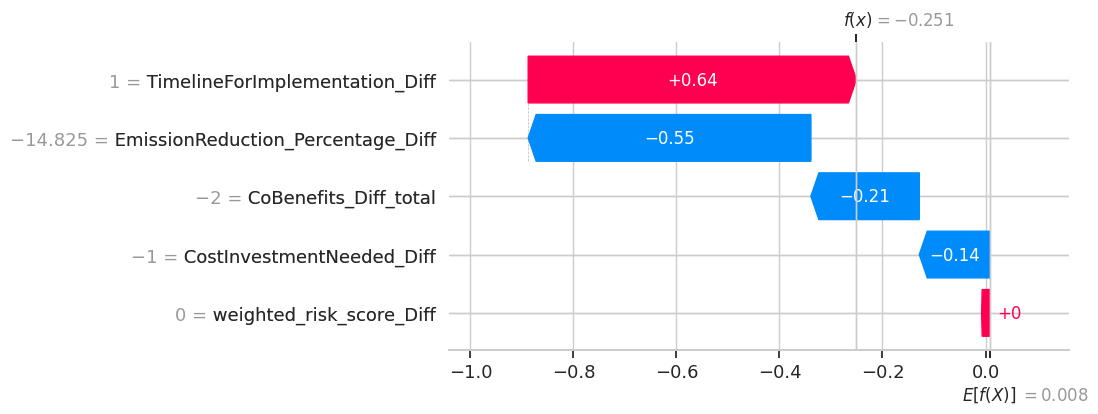

In [ ]:
df_selected_pair = build_df(dict_brmge, dict_c40_0023, dict_c40_0042)
# df_selected_pair = build_df(dict_brmge, dict_c40_0042, dict_c40_0023)

df_X_selected_pair = pipeline_modified(df_selected_pair)
print(df_X_selected_pair.T)

prediction_selected_pair = xgb_clf.predict(df_X_selected_pair)
print(prediction_selected_pair)
if prediction_selected_pair[0] == 1:
    print("Acction A")
else:
    print("Action B")

create_shap_waterfall(df_X_selected_pair, xgb_clf)

                                          0
EmissionReduction_Percentage_Diff  0.000000
CostInvestmentNeeded_Diff         -2.000000
TimelineForImplementation_Diff    -2.000000
weighted_risk_score_Diff           9.100376
CoBenefits_Diff_total             -8.000000
[1]
Acction A


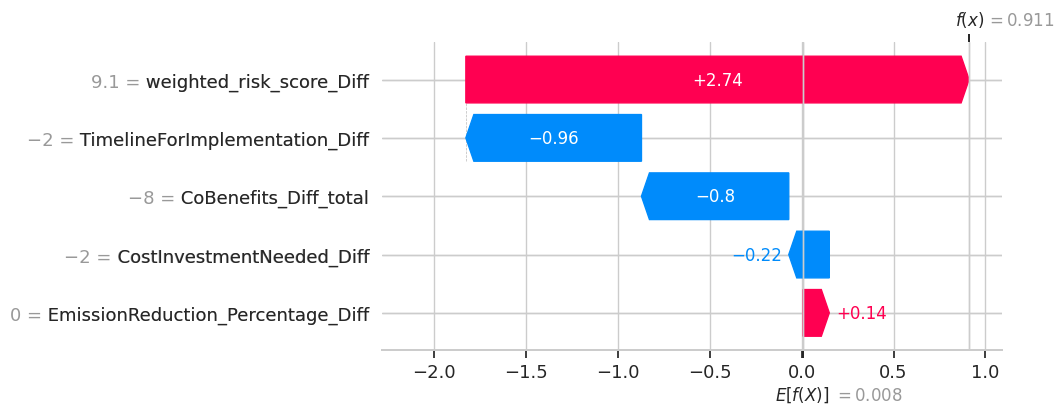

In [ ]:
# df_selected_pair = build_df(dict_brmge, dict_icare_0140, dict_icare_0145)
df_selected_pair = build_df(dict_brcci, dict_icare_0145, dict_icare_0140)

df_X_selected_pair = pipeline_modified(df_selected_pair)
print(df_X_selected_pair.T)

prediction_selected_pair = xgb_clf.predict(df_X_selected_pair)
print(prediction_selected_pair)
if prediction_selected_pair[0] == 1:
    print("Acction A")
else:
    print("Action B")

create_shap_waterfall(df_X_selected_pair, xgb_clf)

#### Using Train-Test Split for training

In the following we use the created train test split.
This is needed to have a holdout data set that we can use in our benchmarking in the CAP prioritizer tool to benchmark against truly unseen data.

In [ ]:
df_test_split

,SessionID,CityLocode,ActionA,ActionB,PreferredAction,note
2315,82200840-e83c-403b-8e23-2ad5e06a6b8e,BRMGE,c40_0071,ipcc_0014,c40_0071,NaN
650,df64ea11-38cb-456d-8dce-c67f5ba3f205,BRCMG,icare_0081,icare_0066,icare_0081,NaN
1983,df64ea11-38cb-456d-8dce-c67f5ba3f205,BRCMG,c40_0024,icare_0116,icare_0116,NaN
177,6524ca15-f41a-46c5-a15c-497ac7c58a6e,BRCXL,c40_0009,ipcc_0031,c40_0009,NaN
1448,33332c30-28ae-412c-9de4-36c9f0baed86,BRCMG,c40_0010,c40_0036,c40_0036,NaN
...,...,...,...,...,...,...
2770,33332c30-28ae-412c-9de4-36c9f0baed86,BRMGE,ipcc_0035,c40_0018,c40_0018,NaN
962,ba995806-a905-47a8-afb5-dacb067e72d8,BRMGE,icare_0175,icare_0145,icare_0145,NaN
2662,022f6466-4742-4c6d-879c-8296f0f38e53,BRRBR,c40_0036,c40_0022,c40_0022,NaN
2276,47f8232c-fa2f-4842-a1ad-81149948240e,BRCMG,ipcc_0029,icare_0018,icare_0018,NaN


In [ ]:
# Prepare the previously splitted data for traininig on hold out dataset for more realisitc performance

df_X_train_split_final, df_y_train_split_final = pipeline(df_train_split)
df_X_test_split_final, df_y_test_split_final = pipeline(df_test_split)

# change y values from -1 and 1 to 0 and 1 - required by xgboost
# df_y_train_split_final = df_y_train_split_final.replace({-1: 0, 1: 1})
# df_y_test_split_final = df_y_test_split_final.replace({-1: 0, 1: 1})

{'c40_0067', 'icare_0189', 'icare_0086', 'ipcc_0035', 'icare_0087', 'c40_0057', 'icare_0106', 'c40_0069', 'ipcc_0032', 'c40_0061', 'c40_0038', 'c40_0063', 'c40_0043', 'icare_0108', 'c40_0050', 'ipcc_0077', 'c40_0064', 'ipcc_0030', 'ipcc_0036', 'c40_0065', 'icare_0098', 'icare_0177', 'c40_0041', 'c40_0070', 'c40_0068'}
(1967, 29)
{'c40_0050', 'ipcc_0077', 'ipcc_0030', 'ipcc_0036', 'c40_0064', 'icare_0086', 'ipcc_0035', 'c40_0065', 'icare_0087', 'c40_0057', 'icare_0106', 'icare_0177', 'c40_0069', 'ipcc_0032', 'c40_0041', 'c40_0038', 'c40_0070', 'c40_0063', 'c40_0043', 'c40_0068', 'icare_0108'}
(495, 29)


In [ ]:
df_X_test_split_final

,EmissionReduction_Percentage_Diff,CostInvestmentNeeded_Diff,TimelineForImplementation_Diff,weighted_risk_score_Diff,CoBenefits_Diff_total
0,-1.493509,2,1,0.000000,-2
1,0.942091,0,0,0.000000,1
2,-0.018135,0,0,0.000000,0
3,0.312101,2,1,0.000000,-2
4,-3.163645,1,0,0.000000,-2
...,...,...,...,...,...
581,0.737581,1,0,0.000000,-3
585,0.000000,1,1,-4.429411,7
586,6.238306,1,1,0.000000,0
587,-0.390650,-1,-1,0.000000,2


In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report

# # Train Logistic Regression Model

# # Class weights could be used for underrepresented classes
# # class_weight={0: 1.0, 1: 1.5, 2: 1.0}
# log_reg = LogisticRegression(solver="lbfgs", max_iter=500, class_weight="balanced")

# log_reg.fit(df_X_train_split_final, df_y_train_split_final)

# # Predictions
# y_pred = log_reg.predict(df_X_test_split_final)

# # Model Evaluation
# accuracy = accuracy_score(df_y_test_split_final, y_pred)
# print(f"Accuracy: {accuracy:.5f}")

# # Print classification report (precision, recall, F1-score per class)
# print("\nClassification Report:")
# print(classification_report(df_y_test_split_final, y_pred))

##### Export final tain-test split

In [ ]:
df_X_train_split_final.columns

Index(['EmissionReduction_Percentage_Diff', 'CostInvestmentNeeded_Diff',
       'TimelineForImplementation_Diff', 'weighted_risk_score_Diff',
       'CoBenefits_Diff_total'],
      dtype='object')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

if training:

    xgb_clf_split = xgb.XGBClassifier(
        objective="binary:logistic",
        max_depth=9,
        learning_rate=0.158,
        n_estimators=800,
        subsample=0.6,
        colsample_bytree=0.7,
        reg_lambda=0.75,
        reg_alpha=0.0,
        scale_pos_weight=1,
        eval_metric='logloss',
        random_state=42,
        monotone_constraints=monotone_constraints_str
    )
    xgb_clf_split.fit(df_X_train_split_final, df_y_train_split_final)
    xgb_clf_split.save_model("/content/xgb_model_train_test_split.json")

    # Predict
    y_pred = xgb_clf_split.predict(df_X_test_split_final)

    # Model Evaluation
    accuracy = accuracy_score(df_y_test_split_final, y_pred)
    print(f"Accuracy: {accuracy:.5f}")

    # Print classification report (precision, recall, F1-score per class)
    print("\nClassification Report:")
    print(classification_report(df_y_test_split_final, y_pred))



Accuracy: 0.64242

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       246
           1       0.64      0.65      0.65       249

    accuracy                           0.64       495
   macro avg       0.64      0.64      0.64       495
weighted avg       0.64      0.64      0.64       495



In [ ]:
# prompt: Create a confucion matrix here with the df_X_test_split_final and y pred of the previous cell

# Generate the confusion matrix
cm = confusion_matrix(df_y_test_split_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Action B', 'Predicted Action A'],
            yticklabels=['Actual Action B', 'Actual Action A'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'confusion_matrix' is not defined

reduced_
Accuracy: 0.69261 42
normal_ Accuracy: 0.71595

reduced_ Accuracy: 0.69262 0
nomral_ Accuracy: 0.68443

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = xgb_clf_split.feature_importances_

# Convert to DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': df_X_train_split_final.columns,  # Replace with actual feature names
    'Importance': feature_importance
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Flip for better visualization
plt.show()

In [ ]:
df_X_train_split_final.columns

In [ ]:
# Convert to LLM-friendly context format (concise and structured)
llm_context = feature_importance_df.to_json(orient='records')

# Display the formatted context
llm_context

In [ ]:
import shap

print("\nGenerating SHAP values...")
explainer = shap.Explainer(xgb_clf_split, df_X_test_split_final)
shap_values = explainer(df_X_test_split_final)

# ========== STEP 4: Global Summary Plot ==========
print("Showing SHAP summary plot...")
shap.summary_plot(shap_values, df_X_test_split_final, plot_type="bar")  # bar or dot

# ========== STEP 5: Individual Prediction Explanation ==========
print("Explaining one prediction (first row)...")
shap.plots.waterfall(shap_values[0])

#### Training 2 individual models

The following code is experimental.

It assumes:
- A binary 'ActionType' column

It trains 2 modesl one for each action type.
The performance seems similar to 1 model for both.
Furhter we would need to also split the training data into 2 buckets, 1 for each action type which reduces the already limited amount of data.

In [ ]:
df_X_train_split_final.columns

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

models = {}

# Simplest approach: Train separate models for each ActionType value
action_types = df_X_train_split_final["ActionType"].unique()
print(f"Unique ActionType values: {action_types}")

# Remove ActionType from features
features_without_action = [col for col in df_X_train_split_final.columns if col != "ActionType"]

# Train a model for each ActionType value
for action_type in action_types:
    print(f"\n--- Training model for ActionType = {action_type} ---")



    # Filter data for this ActionType
    mask_train = df_X_train_split_final["ActionType"] == action_type
    X_train_subset = df_X_train_split_final.loc[mask_train, features_without_action]
    y_train_subset = df_y_train_split_final.loc[mask_train]

    # Train model
    models[f"xgb_clf_{action_type}"] = xgb.XGBClassifier(
        objective="binary:logistic",
        max_depth=9,
        learning_rate=0.136,
        n_estimators=100,
        subsample=0.9,
        colsample_bytree=1,
        reg_lambda=2.25,
        reg_alpha=0.25,
        scale_pos_weight=1,
        eval_metric='logloss',
        random_state=42
    )

    models[f"xgb_clf_{action_type}"].fit(X_train_subset, y_train_subset)

    # Save model
    models[f"xgb_clf_{action_type}"].save_model(f"/content/xgb_model_actiontype_{action_type}.json")

    # Test performance on this ActionType subset
    mask_test = df_X_test_split_final["ActionType"] == action_type
    X_test_subset = df_X_test_split_final.loc[mask_test, features_without_action]
    y_test_subset = df_y_test_split_final.loc[mask_test]

    if len(y_test_subset) > 0:
        y_pred_subset = models[f"xgb_clf_{action_type}"].predict(X_test_subset)
        accuracy = accuracy_score(y_test_subset, y_pred_subset)
        print(f"Accuracy for ActionType {action_type}: {accuracy:.5f}")
        print(classification_report(y_test_subset, y_pred_subset))

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

# Define different KFold objects with different random states
kf1 = KFold(n_splits=5, shuffle=True, random_state=0)  # First set of CV splits
kf2 = KFold(n_splits=5, shuffle=True, random_state=5)  # Second set of CV splits

# Perform cross-validation with different splits
cv_scores1 = cross_val_score(models["xgb_clf_1"], df_X, df_y, cv=kf1, scoring='accuracy')
cv_scores2 = cross_val_score(models["xgb_clf_1"], df_X, df_y, cv=kf2, scoring='accuracy')

# Print results
print("1. CV Scores:", cv_scores1)
# Print mean F1-score and standard deviation
print(f"1. Mean Accuracy: {np.mean(cv_scores1):.4f}")
print(f"1. Standard Deviation: {np.std(cv_scores1):.4f}")

print("2. CV Scores:", cv_scores2)
# Print mean F1-score and standard deviation
print(f"2. Mean Accuracy: {np.mean(cv_scores2):.4f}")
print(f"2. Standard Deviation: {np.std(cv_scores2):.4f}")

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

# Define different KFold objects with different random states
kf1 = KFold(n_splits=5, shuffle=True, random_state=0)  # First set of CV splits
kf2 = KFold(n_splits=5, shuffle=True, random_state=5)  # Second set of CV splits

# Perform cross-validation with different splits
cv_scores1 = cross_val_score(models["xgb_clf_0"], df_X, df_y, cv=kf1, scoring='accuracy')
cv_scores2 = cross_val_score(models["xgb_clf_0"], df_X, df_y, cv=kf2, scoring='accuracy')

# Print results
print("1. CV Scores:", cv_scores1)
# Print mean F1-score and standard deviation
print(f"1. Mean Accuracy: {np.mean(cv_scores1):.4f}")
print(f"1. Standard Deviation: {np.std(cv_scores1):.4f}")

print("2. CV Scores:", cv_scores2)
# Print mean F1-score and standard deviation
print(f"2. Mean Accuracy: {np.mean(cv_scores2):.4f}")
print(f"2. Standard Deviation: {np.std(cv_scores2):.4f}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = models["xgb_clf_1"].feature_importances_

# Convert to DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': X_train_subset.columns,  # Replace with actual feature names
    'Importance': feature_importance
}).sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Flip for better visualization
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = models["xgb_clf_0"].feature_importances_

# Convert to DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': X_train_subset.columns,  # Replace with actual feature names
    'Importance': feature_importance
}).sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Flip for better visualization
plt.show()

Exporting the tree graphs

In [ ]:
xgb.to_graphviz(models["xgb_clf_0"], num_trees=0, format="png").render("tree_graphviz_0", format="png")

In [ ]:
xgb.to_graphviz(models["xgb_clf_1"], num_trees=0, format="png").render("tree_graphviz_1", format="png")